In [1]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# set plot size
plt.rcParams["figure.figsize"] = (20, 13)

%matplotlib inline
%config InlineBackend.figure_format = "retina"


/Users/alexisletrung/perso/epita/FinalProject_2025_Alexis.LE-TRUNG/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Chargement de la donnée


In [2]:
interactions_train = pd.read_csv("./KuaiRec 2.0/data/big_matrix.csv")
interactions_train.head()



,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,0,3649,13838,10867,2020-07-05 00:08:23.438,20200705,1.593879e+09,1.273397
1,0,9598,13665,10984,2020-07-05 00:13:41.297,20200705,1.593879e+09,1.244082
2,0,5262,851,7908,2020-07-05 00:16:06.687,20200705,1.593879e+09,0.107613
3,0,1963,862,9590,2020-07-05 00:20:26.792,20200705,1.593880e+09,0.089885
4,0,8234,858,11000,2020-07-05 00:43:05.128,20200705,1.593881e+09,0.078000


In [3]:
interactions_test = pd.read_csv("./KuaiRec 2.0/data/small_matrix.csv")
interactions_test.head()


,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103
1,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377
2,14,3649,22422,10867,2020-07-05 05:29:09.479,20200705.0,1.593898e+09,2.063311
3,14,5262,4479,7908,2020-07-05 05:30:43.285,20200705.0,1.593898e+09,0.566388
4,14,8234,4602,11000,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364


# Analyse des données

## Informations sur les données

In [4]:
print("=== Informations sur le train ===")
print("Shape:", interactions_train.shape)
print("Colonnes et types :")
print(interactions_train.dtypes)
print("Nombre d'utilisateurs uniques :", interactions_train['user_id'].nunique())
print("Nombre de vidéos uniques :", interactions_train['video_id'].nunique())
if 'timestamp' in interactions_train.columns:
    print("Timestamp min :", interactions_train['timestamp'].min())
    print("Timestamp max :", interactions_train['timestamp'].max())
print("Nombre total d'interactions :", len(interactions_train))
print("Interactions par utilisateur (moyenne, min, max) :", interactions_train['user_id'].value_counts().mean(), interactions_train['user_id'].value_counts().min(), interactions_train['user_id'].value_counts().max())
print("Interactions par vidéo (moyenne, min, max) :", interactions_train['video_id'].value_counts().mean(), interactions_train['video_id'].value_counts().min(), interactions_train['video_id'].value_counts().max())

# Calcul de la densité
n_users_train = interactions_train['user_id'].nunique()
n_videos_train = interactions_train['video_id'].nunique()
density_train = len(interactions_train) / (n_users_train * n_videos_train)
print(f"Densité de la matrice train : {density_train:.2%}")

n_users_test = interactions_test['user_id'].nunique()
n_videos_test = interactions_test['video_id'].nunique()
density_test = len(interactions_test) / (n_users_test * n_videos_test)
print(f"Densité de la matrice test : {density_test:.2%}")


=== Informations sur le train ===
Shape: (12530806, 8)
Colonnes et types :
user_id             int64
video_id            int64
play_duration       int64
video_duration      int64
time               object
date                int64
timestamp         float64
watch_ratio       float64
dtype: object
Nombre d'utilisateurs uniques : 7176
Nombre de vidéos uniques : 10728
Timestamp min : 1592872451.373
Timestamp max : 1599694332.427
Nombre total d'interactions : 12530806
Interactions par utilisateur (moyenne, min, max) : 1746.2104236343366 100 16015
Interactions par vidéo (moyenne, min, max) : 1168.046793437733 1 27615
Densité de la matrice train : 16.28%
Densité de la matrice test : 99.62%


In [5]:
print("\n=== Informations sur le test ===")
print("Shape:", interactions_test.shape)
print("Colonnes et types :")
print(interactions_test.dtypes)
print("Nombre d'utilisateurs uniques :", interactions_test['user_id'].nunique())
print("Nombre de vidéos uniques :", interactions_test['video_id'].nunique())
if 'timestamp' in interactions_test.columns:
    print("Timestamp min :", interactions_test['timestamp'].min())
    print("Timestamp max :", interactions_test['timestamp'].max())
print("Nombre total d'interactions :", len(interactions_test))
print("Interactions par utilisateur (moyenne, min, max) :", interactions_test['user_id'].value_counts().mean(), interactions_test['user_id'].value_counts().min(), interactions_test['user_id'].value_counts().max())
print("Interactions par vidéo (moyenne, min, max) :", interactions_test['video_id'].value_counts().mean(), interactions_test['video_id'].value_counts().min(), interactions_test['video_id'].value_counts().max())


=== Informations sur le test ===
Shape: (4676570, 8)
Colonnes et types :
user_id             int64
video_id            int64
play_duration       int64
video_duration      int64
time               object
date              float64
timestamp         float64
watch_ratio       float64
dtype: object
Nombre d'utilisateurs uniques : 1411
Nombre de vidéos uniques : 3327
Timestamp min : 1593800606.06
Timestamp max : 1599321443.683
Nombre total d'interactions : 4676570
Interactions par utilisateur (moyenne, min, max) : 3314.3656980864635 3295 3327
Interactions par vidéo (moyenne, min, max) : 1405.6417192666065 1315 1411


## 📊 Comparaison des Ensembles de Données : Train vs Test

---

### 🗃️ Dimensions Générales
| Propriété                  | Train                    | Test                     |
|----------------------------|--------------------------|--------------------------|
| Shape                      | (12,530,806, 8)          | (4,676,570, 8)           |
| Nombre total d'interactions | 12,530,806               | 4,676,570                |
| Colonnes                   | 8                        | 8                        |

---

### 🧬 Dtypes des Colonnes
| Colonne           | Type (Train)     | Type (Test)      |
|-------------------|------------------|------------------|
| user_id           | int64            | int64            |
| video_id          | int64            | int64            |
| play_duration     | int64            | int64            |
| video_duration    | int64            | int64            |
| time              | object           | object           |
| date              | int64            | float64 ⚠️       |
| timestamp         | float64          | float64          |
| watch_ratio       | float64          | float64          |

> ⚠️ **Attention** : `date` est de type `int64` dans *train* mais `float64` dans *test*. Cette incohérence peut poser problème lors d'un traitement.

---

### 👥 Utilisateurs
| Propriété                            | Train        | Test         |
|-------------------------------------|--------------|--------------|
| Utilisateurs uniques                | 7,176        | 1,411        |
| Interactions par utilisateur        | Moy: 1,746.21| Moy: 3,314.37|
|                                     | Min: 100     | Min: 3,295   |
|                                     | Max: 16,015  | Max: 3,327   |

---

### 🎬 Vidéos
| Propriété                            | Train        | Test         |
|-------------------------------------|--------------|--------------|
| Vidéos uniques                      | 10,728       | 3,327        |
| Interactions par vidéo              | Moy: 1,168.05| Moy: 1,405.64|
|                                     | Min: 1       | Min: 1,315   |
|                                     | Max: 27,615  | Max: 1,411   |

---

### 🕒 Plages Temporelles
| Propriété             | Train                 | Test                  |
|----------------------|-----------------------|-----------------------|
| Timestamp min        | 1,592,872,451.373     | 1,593,800,606.060     |
| Timestamp max        | 1,599,694,332.427     | 1,599,321,443.683     |

---

## 🔎 Observations et Analyses

- ✅ **Densité du test** :  
  Le test est **quasiment une matrice dense** :  
  - 1,411 utilisateurs × 3,327 vidéos = 4,696,857 interactions possibles  
  - Interactions observées = 4,676,570  
  - **Taux de densité ≈ 99.6%**  
  Cela implique que **chaque utilisateur a quasiment regardé chaque vidéo du test**. 


- 📉 **Train est beaucoup plus sparse** :  
  - 7,176 utilisateurs × 10,728 vidéos = 76,942,128 interactions possibles  
  - Interactions observées = 12,530,806  
  - **Taux de densité ≈ 16.3%**  
  On observe ici une distribution bien plus **réaliste**, avec des utilisateurs regardant un petit sous-ensemble de vidéos.

- ⌛ **Plages temporelles** :
  - Le `train` couvre une période légèrement plus longue, démarrant plus tôt.
  - Le `test` semble centré sur une fenêtre plus courte, mais avec des interactions denses.
  - Ces écarts de timestamp doivent être pris en compte si l'on fait de l'entraînement temporel ou une séparation temporelle stricte.



# Vérification des données NaN et erreur

In [6]:
print(f"=== Vérification des NaN dans le train ===")
for column in interactions_train.columns:
    if interactions_train[column].isna().any():
        print(f"Colonne avec NaN : {column}")

print(f"=== Vérification des NaN dans le test ===")
for column in interactions_test.columns:
    if interactions_test[column].isna().any():
        print(f"Colonne avec NaN : {column}")

print(f"=== Vérification des valeurs négatives dans le train ===")
for column in ['play_duration', 'video_duration', 'watch_ratio', 'timestamp', 'date']:
    if (interactions_train[column] < 0).any():
        print(f"Colonne avec valeurs négatives : {column}")

print(f"=== Vérification des valeurs négatives dans le test ===")
for column in ['play_duration', 'video_duration', 'watch_ratio', 'timestamp', 'date']:
    if (interactions_test[column] < 0).any():
        print(f"Colonne avec valeurs négatives : {column}")


=== Vérification des NaN dans le train ===
=== Vérification des NaN dans le test ===
Colonne avec NaN : time
Colonne avec NaN : date
Colonne avec NaN : timestamp
=== Vérification des valeurs négatives dans le train ===
=== Vérification des valeurs négatives dans le test ===


In [7]:
print(f"=== Ratio de nan dans test sur time/date/timestamp ===")
for column in ['time', 'date', 'timestamp']:
    ratio = interactions_test[column].isna().sum() / len(interactions_test)
    print(f"Column: {column} - Ratio: {ratio:.2%}")

=== Ratio de nan dans test sur time/date/timestamp ===
Column: time - Ratio: 3.89%
Column: date - Ratio: 3.89%
Column: timestamp - Ratio: 3.89%


Les colonnes time, date et timestamp du jeu de test contiennent environ 3.89% de valeurs manquantes. Cela peut poser problème pour les modèles sensibles à la chronologie des interactions, notamment dans les approches séquentielles ou temporelles

# Inspection des données

Vérifions la distribution des interactions des users.

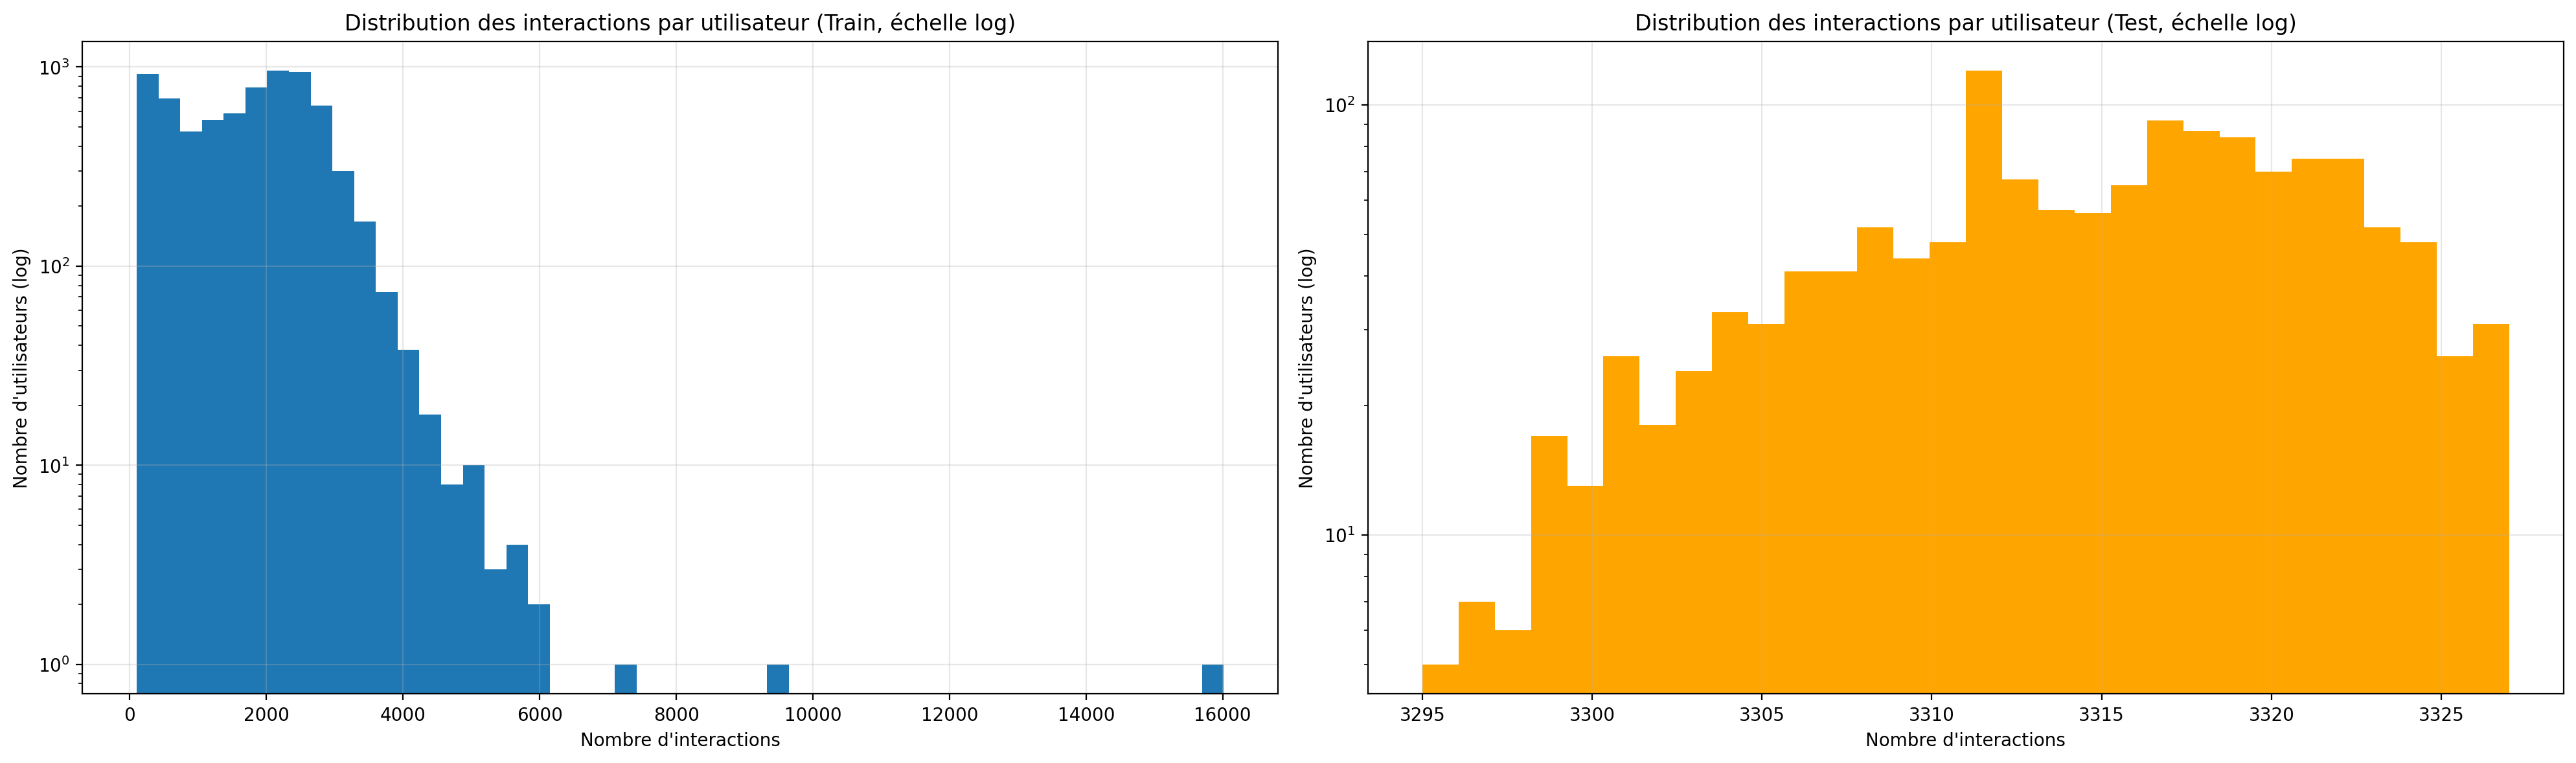

In [8]:
# Calculer le nombre d'interactions par utilisateur pour train et test
user_counts_train = interactions_train["user_id"].value_counts()
user_counts_test = interactions_test["user_id"].value_counts()

# Afficher les deux histogrammes côte à côte
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Histogramme pour le train
axes[0].hist(user_counts_train, bins=50, log=True)
axes[0].set_title("Distribution des interactions par utilisateur (Train, échelle log)")
axes[0].set_xlabel("Nombre d'interactions")
axes[0].set_ylabel("Nombre d'utilisateurs (log)")
axes[0].grid(True, alpha=0.3)

# Histogramme pour le test
axes[1].hist(user_counts_test, bins=30, log=True, color='orange')
axes[1].set_title("Distribution des interactions par utilisateur (Test, échelle log)")
axes[1].set_xlabel("Nombre d'interactions")
axes[1].set_ylabel("Nombre d'utilisateurs (log)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()





## Analyse des Distributions d'Interactions par Utilisateur

### Graphique de Gauche : Distribution des Interactions par Utilisateur (Train, échelle log)
- **Description** : Ce graphique montre la distribution du nombre d'interactions par utilisateur dans l'ensemble d'entraînement.
- **Observations** :
  - La majorité des utilisateurs ont entre 0 et 4000 interactions.
  - Il y a une long tail d'utilisateurs avec un nombre d'interactions allant jusqu'à 16000, indiquant une grande variabilité dans l'activité des utilisateurs.
  - La distribution est fortement inclinée vers les utilisateurs ayant moins d'interactions.

### Graphique de Droite : Distribution des Interactions par Utilisateur (Test, échelle log)
- **Description** : Ce graphique montre la distribution du nombre d'interactions par utilisateur dans l'ensemble de test.
- **Observations** :
  - La distribution est plus concentrée, avec la majorité des utilisateurs ayant entre 3300 et 3325 interactions.
  - La plage de valeurs est plus étroite par rapport à l'ensemble d'entraînement, ce qui indique une segmentation plus uniforme des données de test ce qui montre bien que la matrice de test est quasiment dense.




Vérifions la distribution des interactions des vidéos.

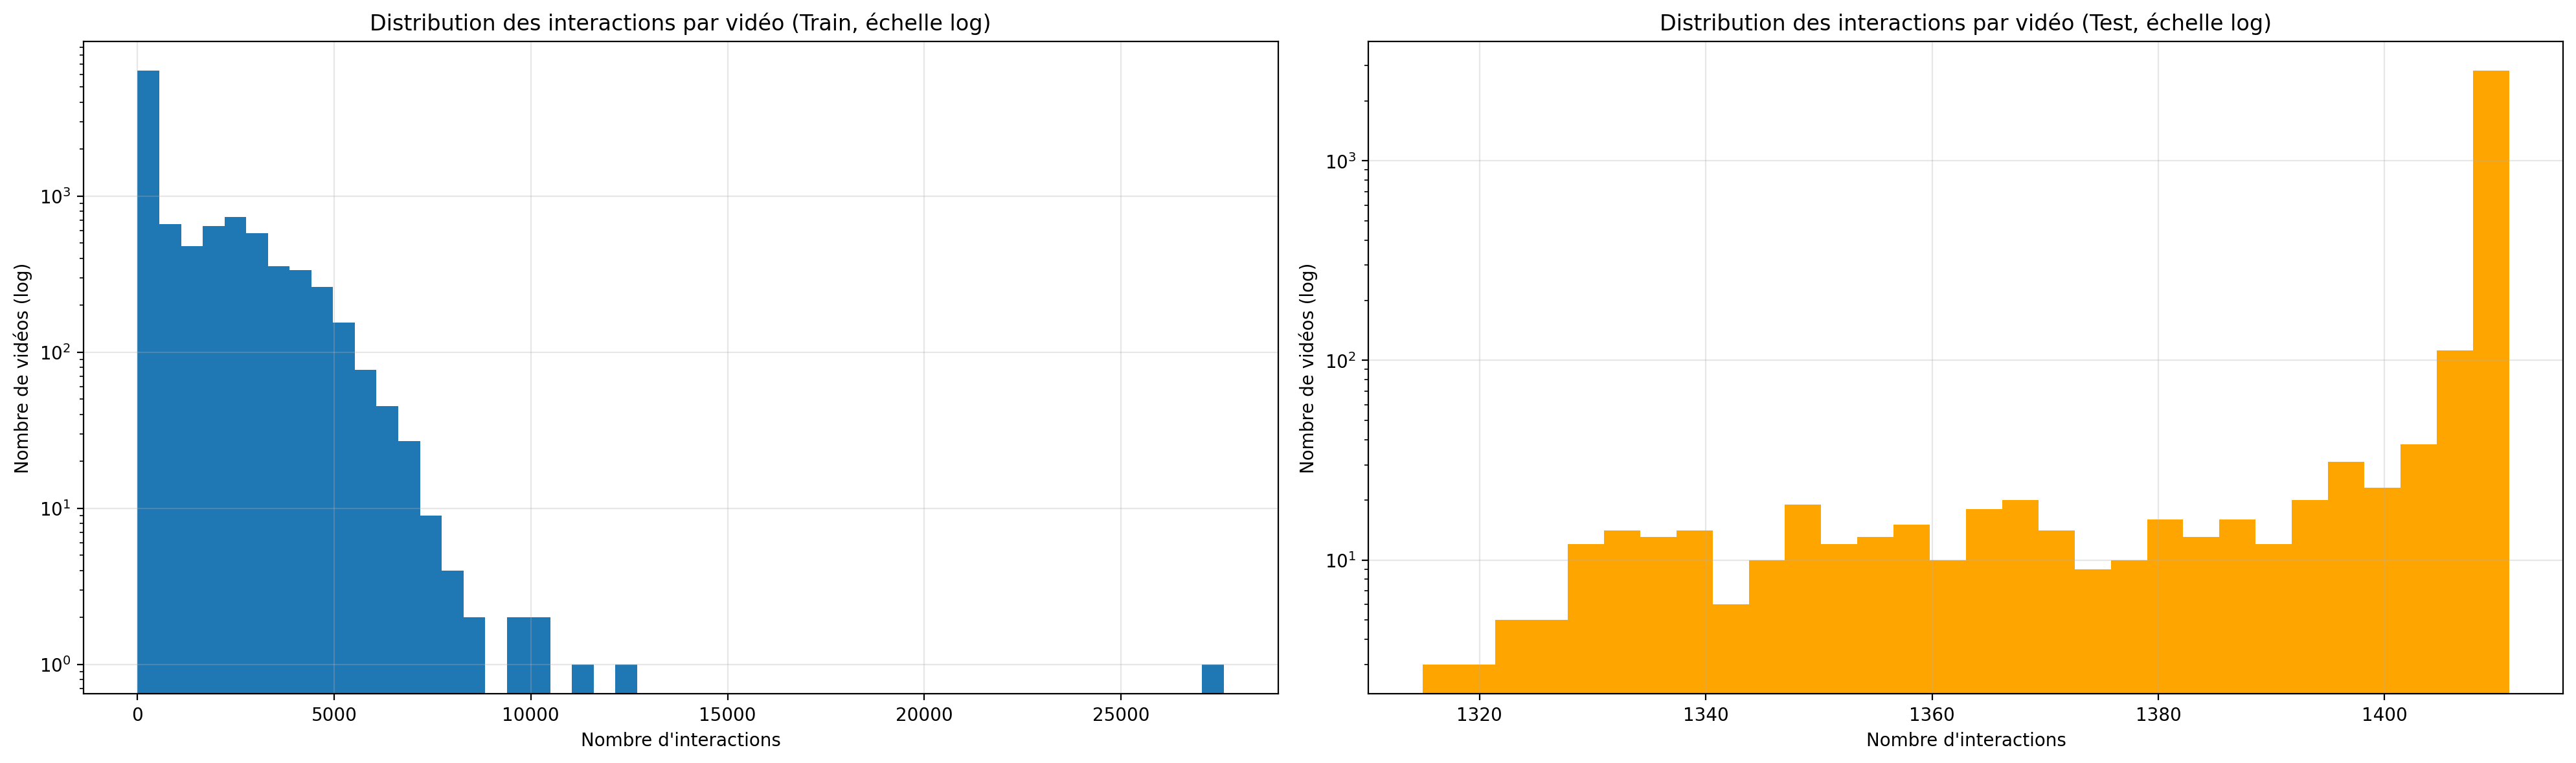

In [9]:
# Calculer le nombre d'interactions par vidéo pour train et test
video_counts_train = interactions_train["video_id"].value_counts()
video_counts_test = interactions_test["video_id"].value_counts()

# Afficher les deux histogrammes côte à côte
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Histogramme pour le train
axes[0].hist(video_counts_train, bins=50, log=True)
axes[0].set_title("Distribution des interactions par vidéo (Train, échelle log)")
axes[0].set_xlabel("Nombre d'interactions")
axes[0].set_ylabel("Nombre de vidéos (log)")
axes[0].grid(True, alpha=0.3)

# Histogramme pour le test
axes[1].hist(video_counts_test, bins=30, log=True, color='orange')

axes[1].set_title("Distribution des interactions par vidéo (Test, échelle log)")
axes[1].set_xlabel("Nombre d'interactions")
axes[1].set_ylabel("Nombre de vidéos (log)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Analyse des Distributions d'Interactions par Vidéo

### Graphique de Gauche : Distribution des Interactions par Vidéo (Train, échelle log)
- **Description** : Ce graphique montre la distribution du nombre d'interactions par vidéo dans l'ensemble d'entraînement.
- **Observations** :
  - La majorité des vidéos ont entre 0 et 5000 interactions.
  - Il y a une long tail de vidéos avec un nombre d'interactions allant jusqu'à 25000, indiquant une grande variabilité dans la popularité des vidéos.
  - La distribution est fortement inclinée vers les vidéos ayant moins d'interactions.

### Graphique de Droite : Distribution des Interactions par Vidéo (Test, échelle log)
- **Description** : Ce graphique montre la distribution du nombre d'interactions par vidéo dans l'ensemble de test.
- **Observations** :
  - La distribution est plus concentrée, avec la majorité des vidéos ayant entre 1320 et 1400 interactions.
  - Il y a un pic notable autour de 1400 interactions, suggérant une certaine uniformité dans la popularité des vidéos dans l'ensemble de test.
  - La plage de valeurs est plus étroite par rapport à l'ensemble d'entraînement, ce qui indique une segmentation plus uniforme des données de test ce qui montre bien que la matrice de test est quasiment dense.




In [10]:
# Transformons les temps en secondes
interactions_train['video_duration'] =interactions_train['video_duration'] / 1000
interactions_train['play_duration'] = interactions_train['play_duration'] / 1000
interactions_test['play_duration'] = interactions_test['play_duration'] / 1000
interactions_test['video_duration'] = interactions_test['video_duration'] / 1000

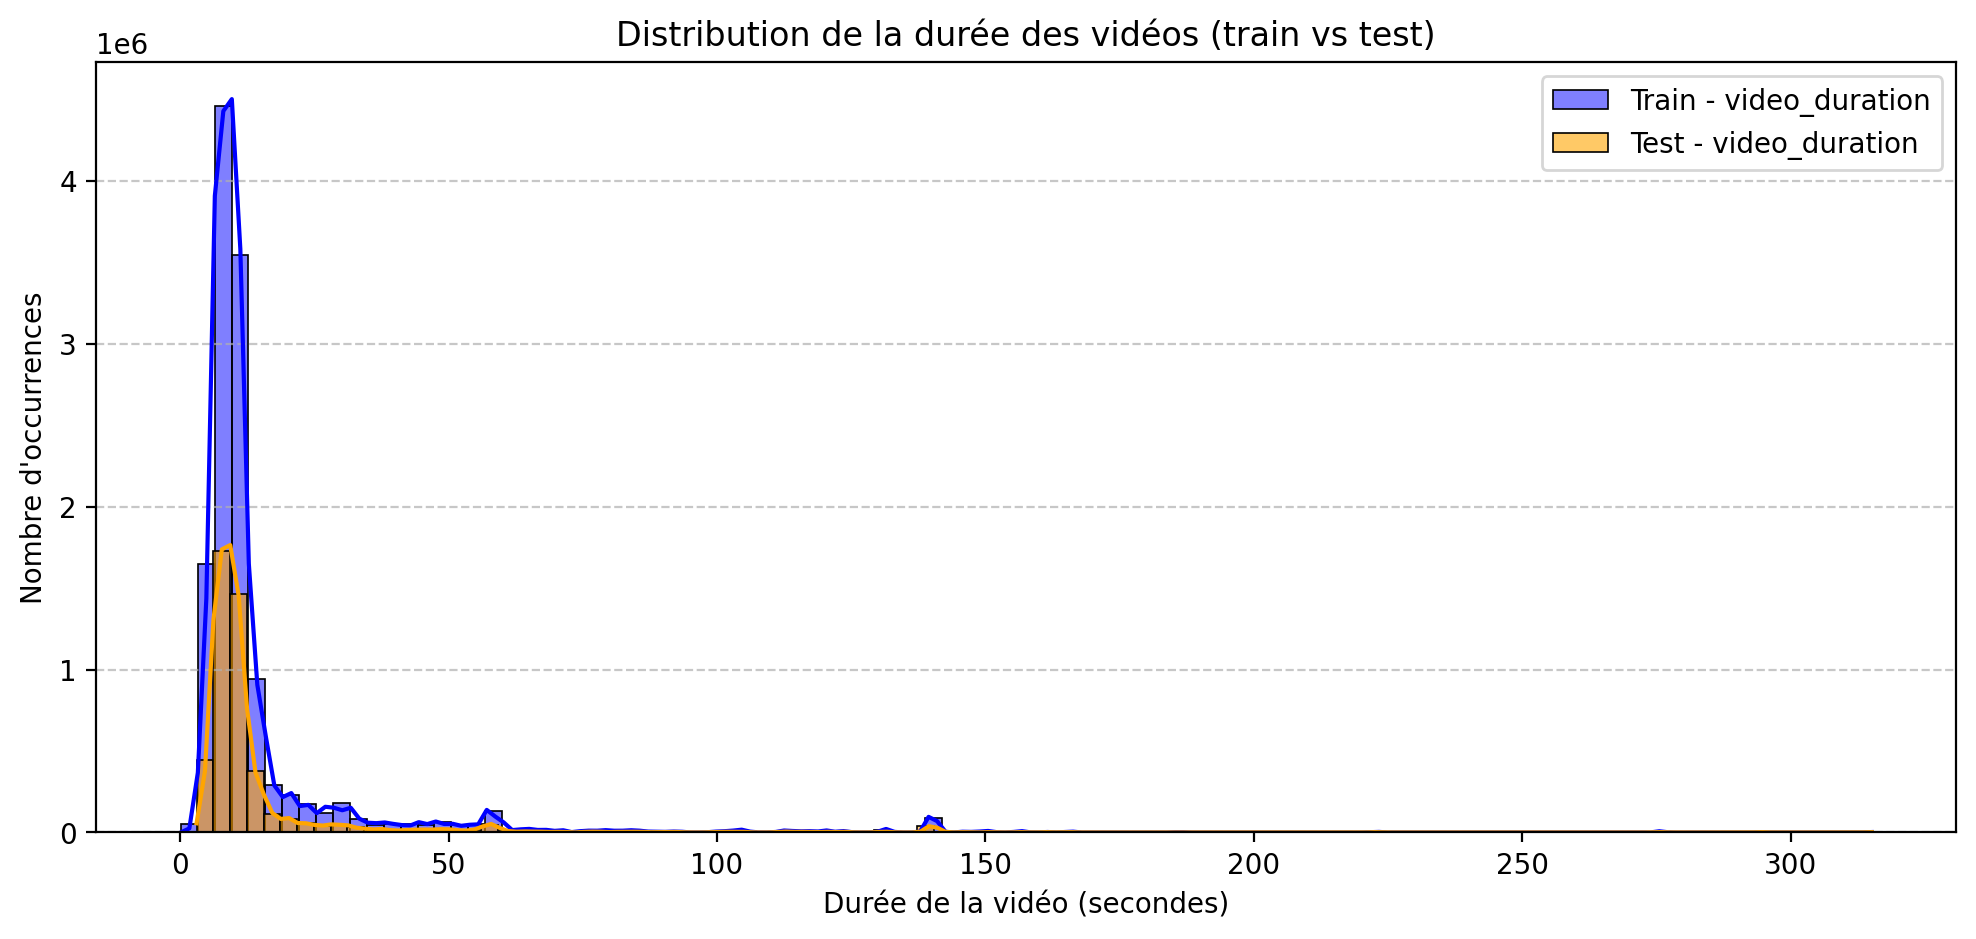

In [11]:
# Tracer la distribution de la durée des vidéos pour le train et le test

# Crée une nouvelle figure de taille 12x5
plt.figure(figsize=(12, 5))

# Trace l'histogramme de la durée des vidéos dans le jeu d'entraînement
sns.histplot(
    interactions_train['video_duration'],
    bins=100,
    kde=True,
    color='blue',
    label='Train - video_duration'
)

# Trace l'histogramme de la durée des vidéos dans le jeu de test (en orange, avec transparence)
sns.histplot(
    interactions_test['video_duration'],
    bins=100,
    kde=True,
    color='orange',
    label='Test - video_duration',
    alpha=0.6
)

# Ajoute un titre au graphique
plt.title("Distribution de la durée des vidéos (train vs test)")
# Ajoute un label à l'axe des abscisses
plt.xlabel("Durée de la vidéo (secondes)")
# Ajoute un label à l'axe des ordonnées
plt.ylabel("Nombre d'occurrences")
# Affiche la légende
plt.legend()
# Ajoute une grille sur l'axe des ordonnées
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Affiche le graphique
plt.show()


In [12]:
print("Train - video_duration min:", interactions_train['video_duration'].min())
print("Train - video_duration max:", interactions_train['video_duration'].max())
print("Test  - video_duration min:", interactions_test['video_duration'].min())
print("Test  - video_duration max:", interactions_test['video_duration'].max())

Train - video_duration min: 0.14
Train - video_duration max: 315.072
Test  - video_duration min: 3.067
Test  - video_duration max: 315.072


## Analyse de la Durée des Vidéos

### Graphique : Distribution de la Durée des Vidéos (Train vs Test)
- **Description** : Ce graphique compare la distribution des durées des vidéos entre les ensembles d'entraînement (`train`) et de test (`test`). L’axe des abscisses représente la durée des vidéos en secondes, et l’axe des ordonnées indique le nombre d’occurrences.
  
- **Observations** :
  - La majorité des vidéos dans les deux ensembles ont une durée très courte, concentrée entre **0 et 20 secondes**.
  - Le pic principal est centré autour de **9 secondes**, aussi bien pour `train` que pour `test`.
  - La distribution est **fortement asymétrique à droite**, avec une longue traîne allant jusqu’à **300 secondes**, ce qui suggère la présence de quelques vidéos exceptionnellement longues.
  - Les distributions de `train` et `test` sont **très similaires**, ce qui indique une bonne homogénéité entre les deux ensembles pour cette variable.
  - L'ensemble `train` contient un volume globalement plus important, comme l’indique la hauteur plus élevée des barres.
  

- **Informations supplémentaires sur les extrêmes**:
  - train : la durée des vidéos varie entre **0.14 secondes et 315.072 secondes**.
  - test : la durée des vidéos varie entre **3.067 secondes et 315.072 secondes**.
  - On remarque que le jeu de test ne contient pas de vidéos très courtes (< 3 secondes), contrairement au train, ce qui peut refléter une différence potentielle de distribution dans les valeurs extrêmes à prendre en compte.


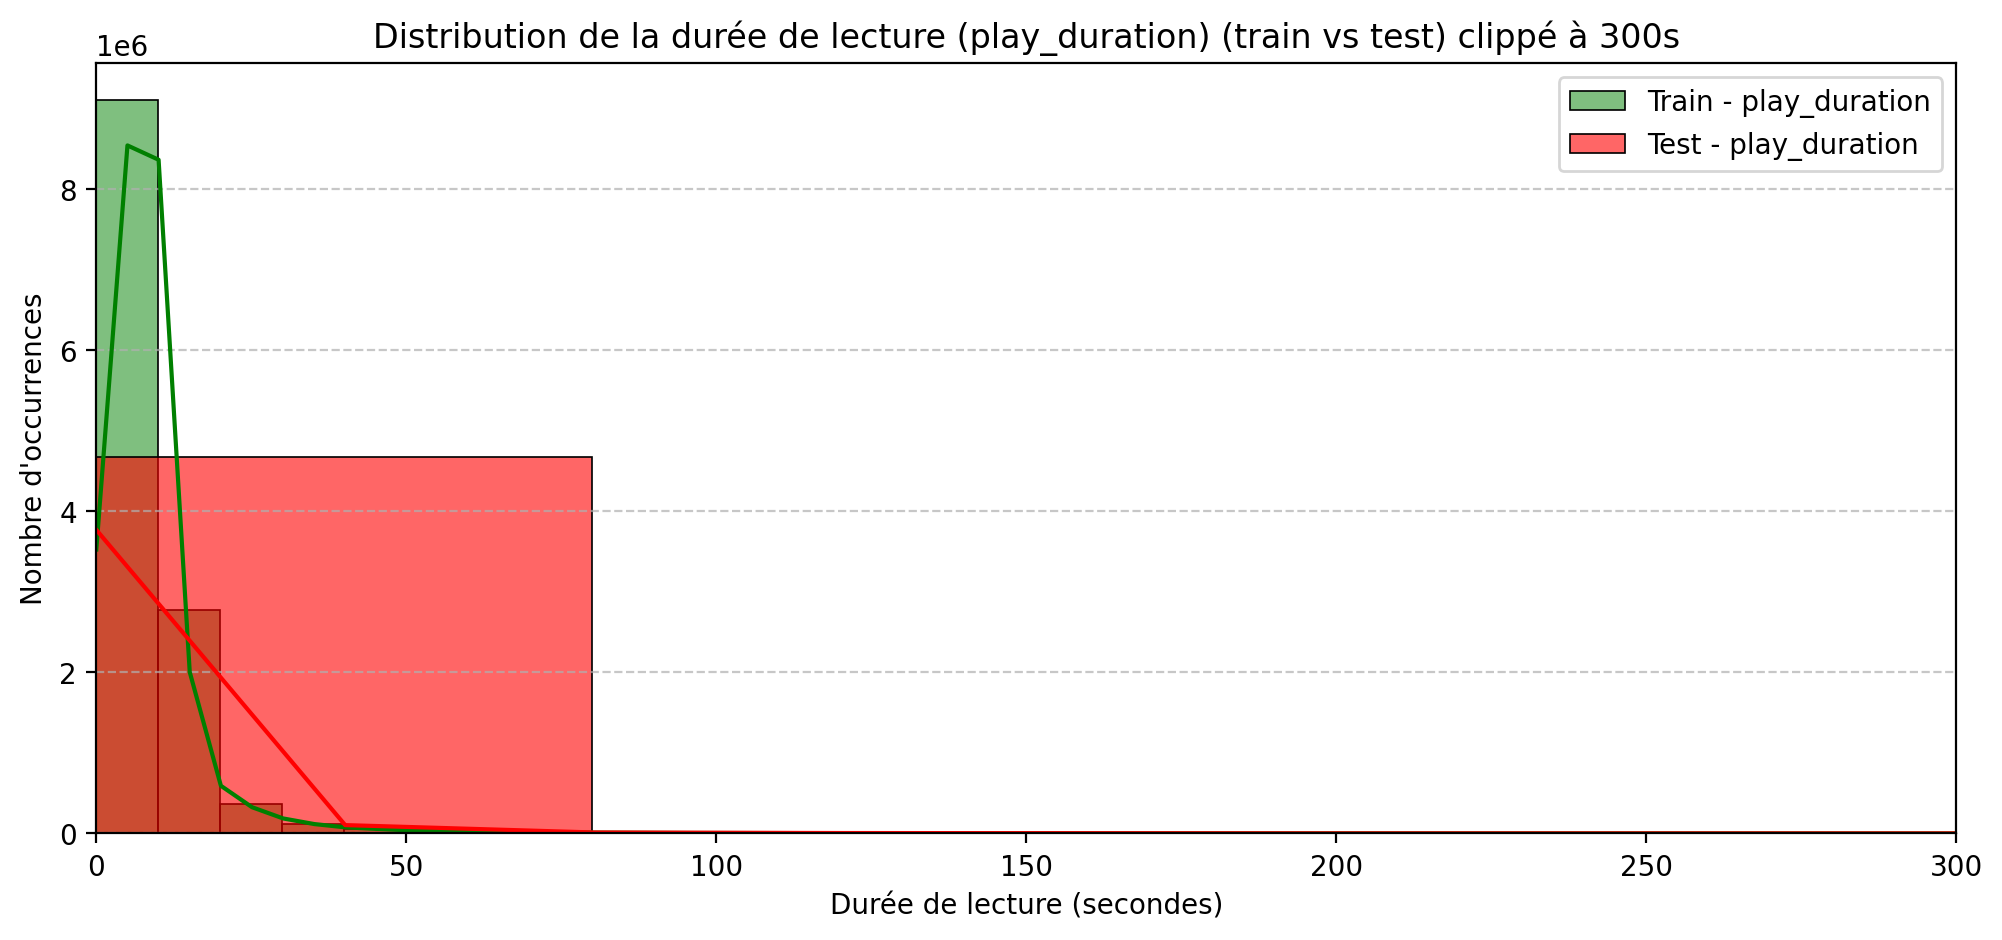

In [13]:
# On trace la distribution de la durée de lecture (play_duration) pour le train et le test
plt.figure(figsize=(12, 5))

# Histogramme pour le train
sns.histplot(
    interactions_train['play_duration'],
    bins=100,
    kde=True,
    color='green',
    label='Train - play_duration'
)

# Histogramme pour le test
sns.histplot(
    interactions_test['play_duration'],
    bins=100,
    kde=True,
    color='red',
    label='Test - play_duration',
    alpha=0.6
)

# Titre et axes
plt.title("Distribution de la durée de lecture (play_duration) (train vs test) clippé à 300s")
plt.xlabel("Durée de lecture (secondes)")
plt.ylabel("Nombre d'occurrences")
plt.xlim(0, 300)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [14]:
print("Train - play_duration min:", interactions_train['play_duration'].min())
print("Train - play_duration max:", interactions_train['play_duration'].max())
print("Test  - play_duration min:", interactions_test['play_duration'].min())
print("Test  - play_duration max:", interactions_test['play_duration'].max())

Train - play_duration min: 0.0
Train - play_duration max: 999.639
Test  - play_duration min: 0.0
Test  - play_duration max: 7988.155


## Analyse de la Durée de lecture des vidéos

### Graphique : Distribution de lecture des vidéos (Train vs Test)

- **Description** : Ce graphique compare la distribution des durées de lecture des vidéos entre les ensembles d'entraînement (`train`) et de test (`test`). L’axe des abscisses représente la durée de lecture des vidéos en secondes, et l’axe des ordonnées indique le nombre d’occurrences.

- **Observations** :
  - La majorité des vidéos dans les deux ensembles ont une durée très courte, concentrée entre **0 et 20 secondes**.
  - Le pic principal est centré autour de **9 secondes**, aussi bien pour `train` que pour `test`.
  - La distribution est **fortement asymétrique à droite**, avec une long tail ce qui suggère la présence de quelques vidéos exceptionnellement longues.
  - Les distributions de `train` et `test` sont **très similaires**, ce qui indique une bonne homogénéité entre les deux ensembles pour cette variable.
  - L'ensemble `train` contient un volume globalement plus important, comme l’indique la hauteur plus élevée des barres.

- **Informations supplémentaires sur les extrêmes** :
  - **Train** : La durée des vidéos varie entre **0.0 secondes et 999.639 secondes**.
  - **Test** : La durée des vidéos varie entre **0.0 secondes et 7988.155 secondes**.
  - On remarque que le jeu de test contient des vidéos plus longues que celles de l'ensemble d'entraînement, avec une durée maximale plus élevée. Cela peut refléter une différence potentielle de distribution dans les valeurs extrêmes à prendre en compte.


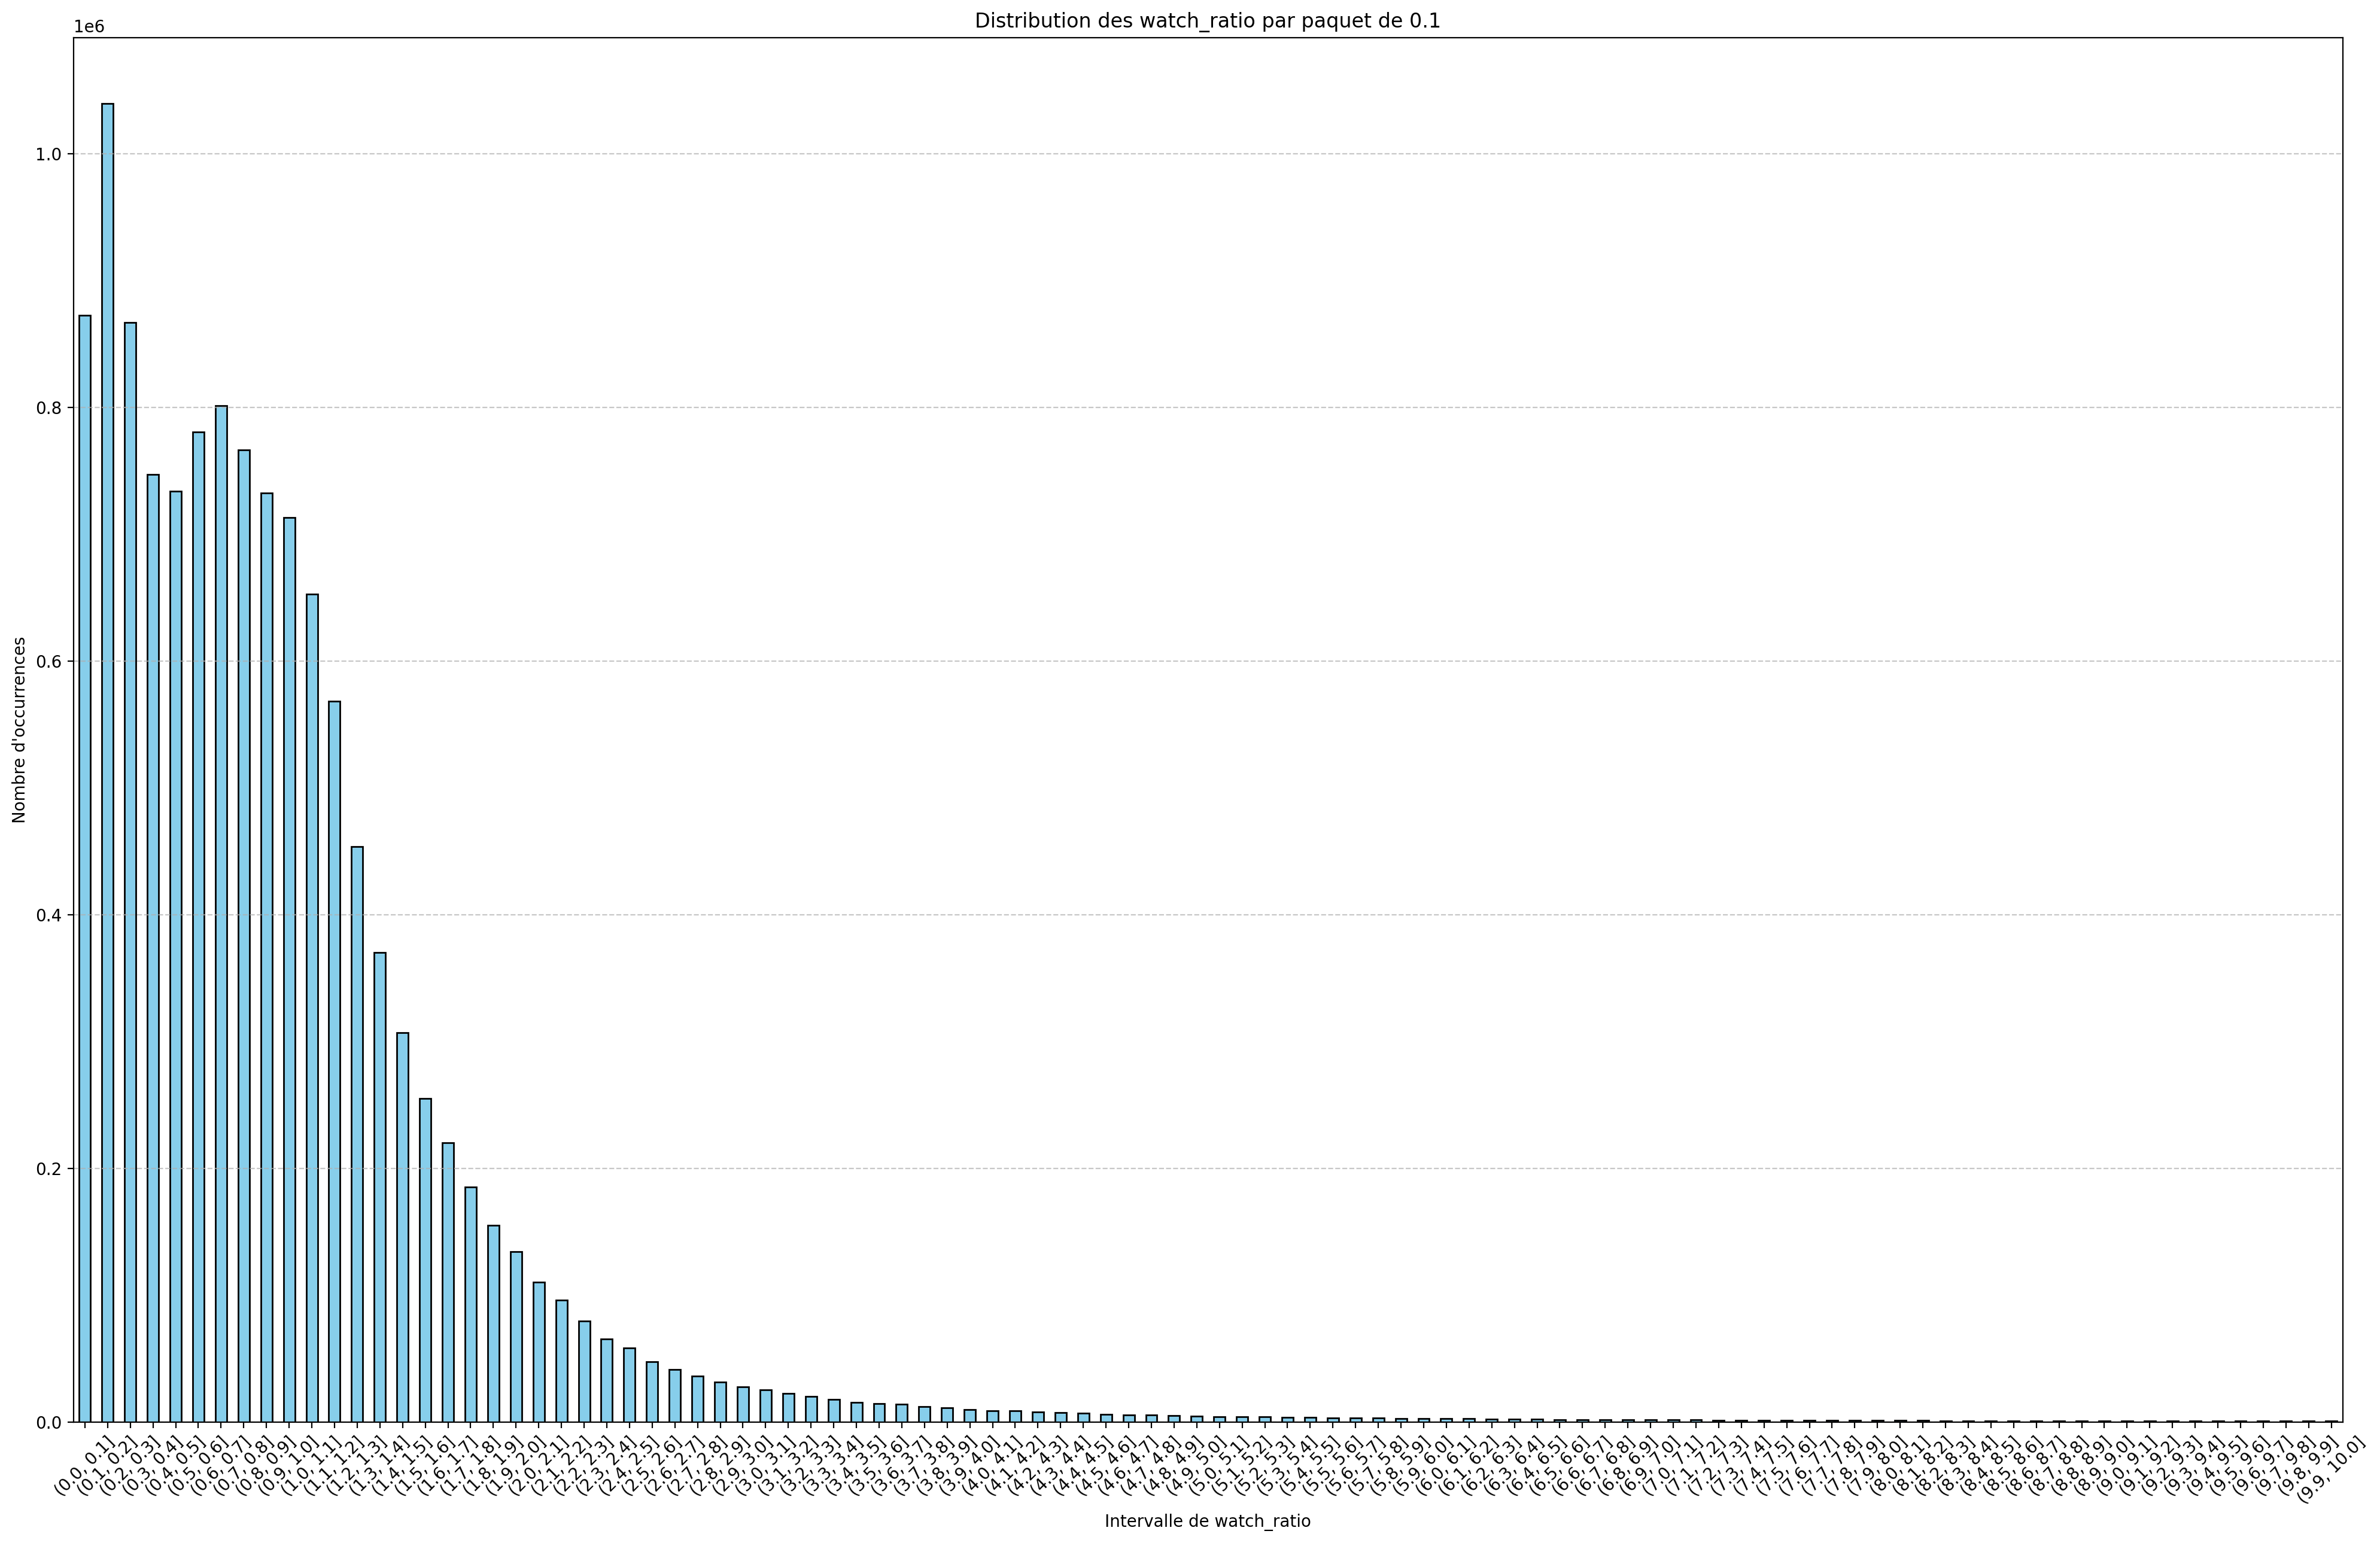

In [15]:
# Créer les bins pour le watch_ratio (de 0 à 10 par pas de 0.1)
watch_ratio_bins = np.arange(0, 10.1, 0.1)
watch_ratio_binned = pd.cut(interactions_train['watch_ratio'], bins=watch_ratio_bins)

# Compter le nombre d'occurrences dans chaque bin
watch_ratio_bin_counts = watch_ratio_binned.value_counts().sort_index()

# Tracer l'histogramme
watch_ratio_bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution des watch_ratio par paquet de 0.1")
plt.xlabel("Intervalle de watch_ratio")
plt.ylabel("Nombre d'occurrences")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Analyse de la distribution du watch_ratio (train)

- **Distribution générale** : La majorité des interactions ont un `watch_ratio` faible, avec un pic marqué dans les premiers intervalles (autour de 0 à 1).
- **Long tail** : On observe une décroissance rapide du nombre d'occurrences à mesure que le `watch_ratio` augmente, mais il existe une long tail jusqu'à 10.
- **Valeurs élevées rares** : Les valeurs de `watch_ratio` supérieures à 2 sont beaucoup plus rares, ce qui indique que peu d'utilisateurs regardent plusieurs fois la même vidéo ou la visionnent en boucle.
- **Comportement utilisateur** : Cette distribution suggère que la plupart des utilisateurs regardent les vidéos une seule fois ou partiellement, ce qui est typique pour des contenus courts.


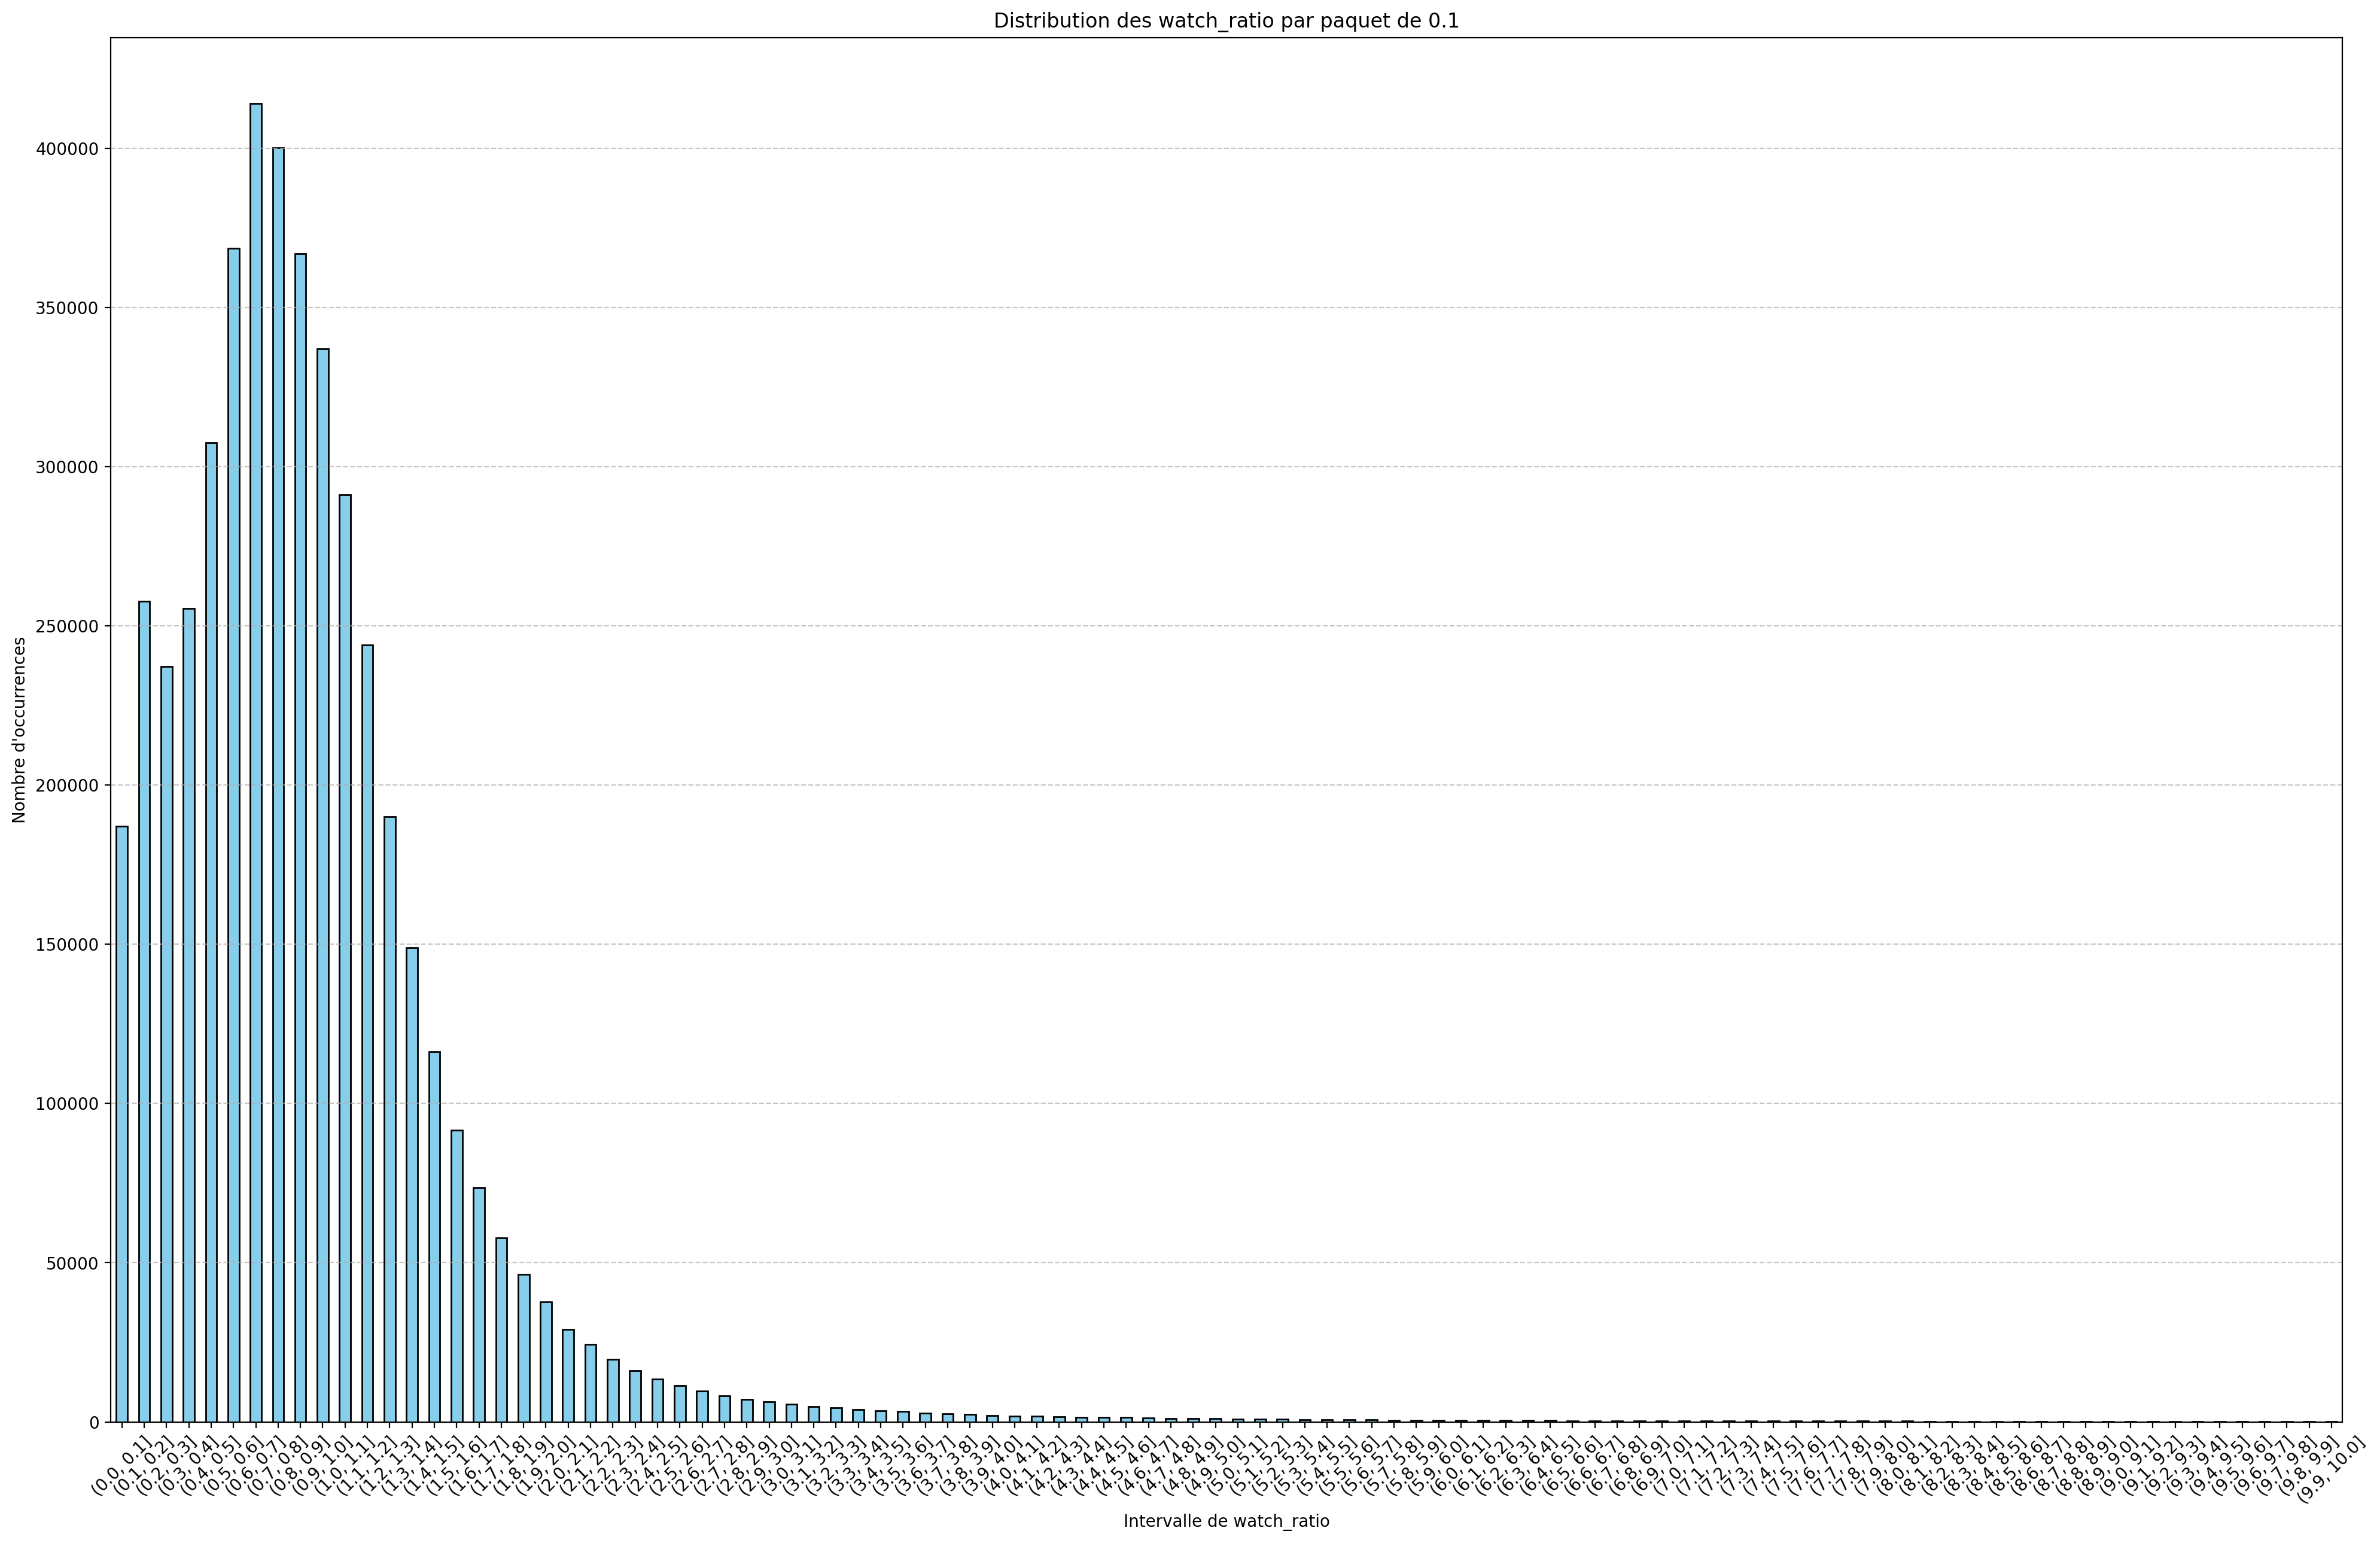

In [16]:
# Créer les bins pour le watch_ratio (de 0 à 10 par pas de 0.1)
watch_ratio_bins = np.arange(0, 10.1, 0.1)
watch_ratio_binned = pd.cut(interactions_test['watch_ratio'], bins=watch_ratio_bins)

# Compter le nombre d'occurrences dans chaque bin
watch_ratio_bin_counts = watch_ratio_binned.value_counts().sort_index()

# Tracer l'histogramme
watch_ratio_bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution des watch_ratio par paquet de 0.1")
plt.xlabel("Intervalle de watch_ratio")
plt.ylabel("Nombre d'occurrences")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Analyse de la distribution du watch_ratio (test) et comparaison avec le train

- **Distribution générale (test)** :  
    La majorité des interactions dans le jeu de test ont un `watch_ratio` faible, avec un pic marqué dans les premiers intervalles (autour de 0 à 1), similaire à ce qui est observé dans le train.

- **Long tail** :  
    On observe également une décroissance rapide du nombre d'occurrences à mesure que le `watch_ratio` augmente, avec une longue traîne jusqu'à 10. Les valeurs élevées de `watch_ratio` restent rares.

- **Comparaison avec le train** :  
    La forme de la distribution dans le test est très proche de celle du train :  
    - Dans les deux ensembles, la majorité des interactions se situent dans les premiers bins (0 à 1).
    - Les valeurs de `watch_ratio` supérieures à 2 sont peu fréquentes dans les deux cas.
    - La densité du test étant plus élevée, le nombre absolu d'occurrences par bin est plus homogène, mais la tendance générale reste la même.

- **Comportement utilisateur** :  
    Cela confirme que, même dans un contexte où chaque utilisateur a vu presque toutes les vidéos (test dense), la plupart des vidéos ne sont regardées qu'une seule fois ou partiellement.



## Choix de la Méthode de Recommandation

### Justification du Filtrage Collaboratif

Mon choix du **filtrage collaboratif** repose sur les caractéristiques des données d’interactions disponibles, et sur les hypothèses que cette méthode exploite efficacement. Voici les raisons principales motivant mon choix :

---

### 1. Exploitation directe des interactions

- **Pas besoin de contenu explicite**  
  Le filtrage collaboratif se base uniquement sur les interactions passées entre utilisateurs et vidéos, sans nécessiter de descriptions de vidéos. Cela est optimale car dans mon contexte il y a peu d'information sur les vidéos.

---

### 2. Capacité à capturer des préférences implicites

- **Détection des schémas comportementaux**  
  En apprenant à partir de l’historique d’interactions, cette méthode peut détecter des patterns de co-consommation entre utilisateurs et vidéos ce qui est pertinent ici car il y a pas de rating expliciting uniquement le temps de visionage des vidéos.

---


### 3. Pré-requis satisfaits dans notre contexte

- **Présence d’un historique suffisant**  
  Le filtrage collaboratif est peu efficace en cas de problème de *cold start*. Dans notre cas, la matrice de test ne contient pas de nouveaux utilisateurs/vidéos ce qui est idéale pour le collaboratif.

---

### 4. Homogénéité des Données
Les distributions des durées de lecture,des durées des vidéos et du watch ratio sont très similaires entre les ensembles d'entraînement et de test. Cela indique une bonne homogénéité, ce qui est bénéfique pour le filtrage collaboratif car il permet de généraliser les modèles de recommandation.


---

### Limites à considérer

- **Sensibilité aux vidéos ou utilisateurs très actifs**  
  Les profils ou vidéos ayant beaucoup d’interactions peuvent dominer les recommandations. 

- **Problème de sparsité**  
  La matrice d’interactions est très creuse, les performances du filtrage collaboratif peuvent être limitées.

---

### Conclusion

Le filtrage collaboratif constitue une solution adaptée dans notre cas, car :

- Il exploite directement les interactions disponibles, sans besoin de données supplémentaires.
- Il est capable de fournir des recommandations personnalisées à partir des similarités d’usage.
- Les conditions nécessaires à son efficacité (volume d’interactions, variété de comportements) sont réunies.




---


Dans le cadre de l’approche de filtrage collaboratif retenue, les colonnes time, date et timestamp ne seront pas prises en compte. En effet, le filtrage collaboratif s’appuie exclusivement sur les interactions entre utilisateurs et vidéos, sans exploiter les informations temporelles. Ces variables pourraient s’avérer pertinentes dans le contexte de modèles séquentiels ou temporels, mais elles ne sont pas nécessaires ni exploitées dans la méthodologie adoptée ici.


In [17]:
interactions_train = interactions_train.drop(columns=['time', 'date', 'timestamp'])
interactions_test = interactions_test.drop(columns=['time', 'date', 'timestamp'])

Le problème de cohérence de types et de valeurs manquantes dans le jeu de test a été résolu : les colonnes problématiques ont été supprimées et les données sont désormais prêtes pour l'analyse et la modélisation. Nous pouvons donc poursuivre sans contrainte liée à la structure du jeu de test.

---
Nous allons voir si il existe des doublons dans les d'interactions


In [18]:
dups_train = interactions_train.groupby(['user_id', 'video_id']).size().reset_index(name='count')
dups_train = dups_train[dups_train['count'] > 1]
print(f"=== Ratio de doublons dans train ===")
print(f"Ratio des doublons: {len(dups_train) / len(interactions_train)}")
print(f"Nombre des doublons: {len(dups_train)}")

dups_test = interactions_test.groupby(['user_id', 'video_id']).size().reset_index(name='count')
dups_test = dups_test[dups_test['count'] > 1]
print(f"=== Ratio de doublons dans test ===")
print(f"Ratio des doublons: {len(dups_test) / len(interactions_test)}")
print(f"Nombre des doublons: {len(dups_test)}")

=== Ratio de doublons dans train ===
Ratio des doublons: 0.1469613367248683
Nombre des doublons: 1841544
=== Ratio de doublons dans test ===
Ratio des doublons: 0.0
Nombre des doublons: 0


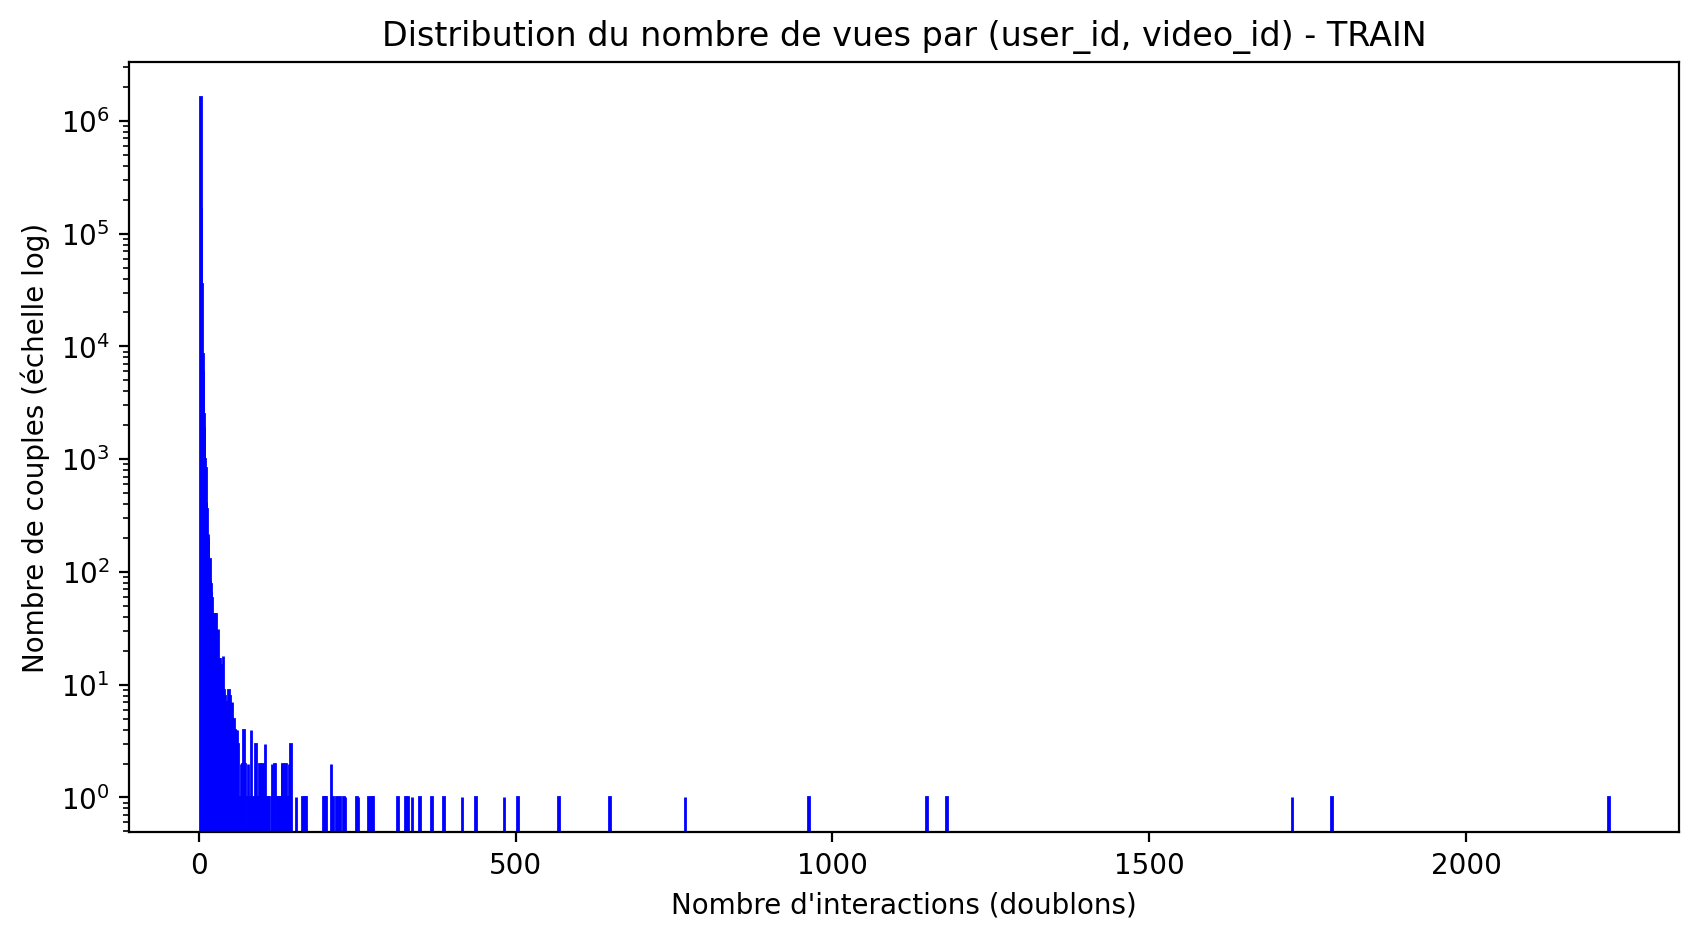

In [19]:
# Visualiser la distribution des doublons dans le train
plt.figure(figsize=(10, 5))
plt.hist(dups_train['count'], bins=range(1, dups_train['count'].max() + 2), edgecolor='blue', log=True)
plt.title("Distribution du nombre de vues par (user_id, video_id) - TRAIN")
plt.xlabel("Nombre d'interactions (doublons)")
plt.ylabel("Nombre de couples (échelle log)")
plt.grid(False)
plt.show()





- **interaction_train** : Contient plus de 1,8 million de couples (user_id, video_id) ayant des doublons dans le train. Cela signifie que certains utilisateurs ont interagi plusieurs fois avec la même vidéo, ce qui est courant sur des plateformes de vidéos courtes (replay, boucle, etc.). Il faudra agréger ces interactions (par exemple, somme du `watch_ratio`) pour obtenir une matrice utilisateur-vidéo exploitable.

- **interaction_test** : Pas de doublons dans le jeu de test. Chaque couple (user_id, video_id) apparaît une seule fois dans le test.


- **Histogramme des doublons** :  
    Le graphique montre la distribution du nombre d'interactions pour chaque couple (user_id, video_id) ayant des doublons dans le train. On observe que la majorité des doublons correspondent à 2 interactions, mais certains couples peuvent apparaître plus de 10 fois. Cela illustre la fréquence des replays ou boucles sur certaines vidéos courtes.  
    Pour l'analyse, il est donc pertinent d'agréger ces doublons afin de refléter l'engagement total de l'utilisateur sur chaque vidéo.


Avant d'aggréger, il serait pertinent de vérifier les doublons pour voir des potentiels problèmes. Notamment si il y a une différence de durée de vidéo qui doit être le même pour chaque interaction. 

In [20]:
# Garder uniquement les doublons (count > 1)
dups = dups_train[dups_train['count'] > 1][['user_id', 'video_id']]

# Calculer la différence max-min de video_duration pour chaque doublon
duration_diff = (
    interactions_train
    .merge(dups, on=['user_id', 'video_id'])
    .groupby(['user_id', 'video_id'])['video_duration']
    .agg(['min', 'max'])
    .reset_index()
)
duration_diff['diff'] = duration_diff['max'] - duration_diff['min']

# Garder uniquement les cas où la différence dépasse 1 seconde
diff_gt_0s = duration_diff[duration_diff['diff'] > 0.0]
diff_gt_1s = duration_diff[duration_diff['diff'] > 1.0]


# Afficher les shapes
print(f"Shape de diff_gt_0s: {diff_gt_0s.shape}")
print(f"Shape de diff_gt_1s: {diff_gt_1s.shape}")

# Afficher les résultats
print(diff_gt_0s.head(3))
print(diff_gt_1s.head())

Shape de diff_gt_0s: (33014, 5)
Shape de diff_gt_1s: (2, 5)
     user_id  video_id     min     max   diff
84         0      2917  12.667  12.688  0.021
125        0      4307  11.384  11.434  0.050
147        0      5291   6.711   6.767  0.056
         user_id  video_id     min     max    diff
1039225     4045      1169  14.917  80.013  65.096
1371462     5308      9652   8.081  11.495   3.414


Il y a  33 014 couples (user_id, video_id) présentant des doublons avec une différence de durée de vidéo. Après analyse, la grande majorité de ces écarts sont très faibles et peuvent être considérés comme des variations mineures acceptables, probablement dues à des imprécisions de mesure ou d'encodage.

Cependant, deux cas spécifiques présentent une différence de durée supérieure à une seconde, ce qui constitue une anomalie notable. Nous allons examiner en détail ces deux couples afin d'évaluer la nature de cette incohérence et d'adapter le traitement des données en conséquence.

In [21]:
# Afficher toutes les lignes du DataFrame interactions_train correspondant à un doublon précis
# Exemple : pour le premier doublon trouvé dans dups_train
def display_duplicate_rows(user_id, video_id):
    duplicate_rows = interactions_train[(interactions_train['user_id'] == user_id) & (interactions_train['video_id'] == video_id)]
    return duplicate_rows

print(display_duplicate_rows(4045, 1169))
print(display_duplicate_rows(5308, 9652))


         user_id  video_id  play_duration  video_duration  watch_ratio
7084227     4045      1169          0.000          14.944     0.000000
7084228     4045      1169          0.000          14.917     0.000000
7084229     4045      1169          0.000          14.944     0.000000
7084230     4045      1169          8.182          80.013     0.102258
         user_id  video_id  play_duration  video_duration  watch_ratio
9339665     5308      9652          3.588          11.495     0.312136
9339856     5308      9652          4.968           8.081     0.614775


Dans le cadre de l’assurance qualité des données, deux couples (user_id, video_id) ont été identifiés comme présentant une incohérence notable : la durée de la vidéo associée diffère de plus d’une seconde entre plusieurs interactions. Cette variation, non justifiable par la nature des données, constitue une anomalie potentielle. Afin de garantir l’intégrité et la cohérence de l’ensemble d’entraînement, ces cas isolés ont été exclus de l’analyse ultérieure.

In [22]:
# Supprimer dans interactions_train les interactions pour (user_id, video_id) = (5308, 9652) et (4045, 1169)
interactions_train = interactions_train[
    ~(
        ((interactions_train['user_id'] == 5308) & (interactions_train['video_id'] == 9652)) |
        ((interactions_train['user_id'] == 4045) & (interactions_train['video_id'] == 1169))
    )
]

Pour l’agrégation des données, chaque couple (user_id, video_id) peut apparaître plusieurs fois dans le jeu d’entraînement, traduisant des visionnages répétés à des moments différents. Afin de refléter l’engagement total de l’utilisateur pour une vidéo, j’agrège la variable `watch_ratio` en effectuant une somme sur l’ensemble des interactions du couple. Pour les autres variables (`play_duration`, `video_duration`), j’utilise la valeur de la dernière interaction, car j'ai vérifié et supprimé les cas présentant des incohérences de durée. Cette méthode permet de conserver un signal d’engagement pertinent tout en assurant la cohérence des autres attributs.

In [23]:
interactions_train_filtered = (
    interactions_train
    .sort_values(['user_id', 'video_id'])
    .groupby(['user_id', 'video_id'], as_index=False)
    .agg({
        'watch_ratio': 'sum',
        'play_duration': 'last',
        'video_duration': 'last'
    })
)

interactions_test_filtered = (
    interactions_test
    .sort_values(['user_id', 'video_id'])
    .groupby(['user_id', 'video_id'], as_index=False)
    .agg({
        'watch_ratio': 'sum',
        'play_duration': 'last',
        'video_duration': 'last'
    })
)


## Choix du Seuil pour Définir une Interaction "Relevant"
---

Pour déterminer si une interaction utilisateur-vidéo doit être considérée comme "relevant" (c'est-à-dire que l'utilisateur a réellement apprécié ou été engagé par la vidéo), il est nécessaire de fixer un seuil sur la variable `watch_ratio`. 

- **Justification du seuil** :  
    - Un `watch_ratio` élevé indique que l'utilisateur a regardé la vidéo en entier, voire plusieurs fois, ce qui traduit un fort engagement.
    - Un seuil trop bas risquerait d'inclure des interactions peu significatives (visionnage partiel ou accidentel).
    - Un seuil trop haut exclurait des cas où l'utilisateur a apprécié la vidéo mais ne l'a vue qu'une seule fois.

- **Cas particulier des vidéos courtes** :  
    - Pour les vidéos de moins de 10 secondes, il est courant que les utilisateurs les regardent plusieurs fois (effet boucle). Un seuil plus élevé (par exemple `watch_ratio >= 2.0`) permet de ne retenir que les interactions les plus engageantes.
    - Pour les vidéos plus longues, un seuil plus bas (par exemple `watch_ratio >= 1.0`) est plus adapté, car il est moins probable qu'un utilisateur regarde plusieurs fois une vidéo longue.

- **Décision** :  
    - **Vidéos ≤ 10s** : une interaction est "relevante" si `watch_ratio >= 2.0`
    - **Vidéos > 10s** : une interaction est "relevante" si `watch_ratio >= 1.0`


**Conclusion** :
Ce choix permet de mieux cibler les interactions réellement pertinentes pour la recommandation, en tenant compte de la spécificité des formats courts. Ce seuil est volontairement élevé car mon objectif est de trouver une logique qui montre réellement l'engagement de l'utilisateur.


En effet, si un utilisateur regarde une vidéo une fois en entier, cela ne fournit pas suffisamment d'informations pour déterminer s'il l'a aimée, car il peut tout aussi bien l'avoir aimée que non. En revanche, s'il regarde une vidéo deux fois de suite, bien que cela soit rare, cela montre un fort engagement et peut être un indicateur plus fiable de son intérêt.

Cependant, il est important de noter que cela dépend aussi de la taille de la vidéo, car regarder une vidéo plus longue en entier peut être un indicateur plus fort d'intérêt que de regarder une vidéo plus courte.

Vérifions qu'il y a une différence de watch_ratio selon la durée de la vidéo pour justifier mon choix

In [24]:
# Moyenne du watch_ratio pour les vidéos de moins de 10 secondes
mean_watch_ratio_lt_10 = interactions_train_filtered[interactions_train_filtered['video_duration'] <= 10]['watch_ratio'].mean()
# Moyenne du watch_ratio pour les vidéos de plus de 10 secondes
mean_watch_ratio_gt_10 = interactions_train_filtered[interactions_train_filtered['video_duration'] > 10]['watch_ratio'].mean()

print(f"Moyenne du watch_ratio pour les vidéos <= 10s : {mean_watch_ratio_lt_10:.3f}")
print(f"Moyenne du watch_ratio pour les vidéos > 10s  : {mean_watch_ratio_gt_10:.3f}")

Moyenne du watch_ratio pour les vidéos <= 10s : 1.453
Moyenne du watch_ratio pour les vidéos > 10s  : 0.777


La différence observée dans la moyenne du `watch_ratio` selon la durée des vidéos (plus élevée pour les vidéos courtes) confirme la pertinence d'utiliser un seuil différencié pour définir une interaction "relevant". Mon choix est donc justifié par la distribution réelle des comportements utilisateurs.

In [25]:
# Ajout d'une colonne 'relevant' selon la règle du seuil dépendant de la durée de la vidéo
interactions_train_filtered['relevant'] = np.where(
    interactions_train_filtered.loc[
        interactions_train_filtered.index, 'video_duration'
    ] <= 10,
    np.where(interactions_train_filtered['watch_ratio'] >= 2.0, 1, 0),
    np.where(interactions_train_filtered['watch_ratio'] >= 1.0, 1, 0)
)

interactions_test_filtered['relevant'] = np.where(
    interactions_test_filtered.loc[
        interactions_test_filtered.index, 'video_duration'
    ] <= 10,
    np.where(interactions_test_filtered['watch_ratio'] >= 2.0, 1, 0),
    np.where(interactions_test_filtered['watch_ratio'] >= 1.0, 1, 0)
)

Vérifions la proportion d'interaction jugée comme 'relevant'

In [26]:
# Proportion de vidéos avec watch_ratio > 2 sur vidéos <= 10s (train)
train_10s = interactions_train['video_duration'] <= 10
prop_train_short = (interactions_train.loc[train_10s, 'watch_ratio'] > 2).mean()

# Proportion de vidéos avec watch_ratio > 1 sur vidéos > 10s (train)
train_long = interactions_train['video_duration'] > 10
prop_train_long = (interactions_train.loc[train_long, 'watch_ratio'] > 1).mean()

# Proportion de vidéos avec watch_ratio > 2 sur vidéos <= 10s (test)
test_10s = interactions_test['video_duration'] <= 10
prop_test_short = (interactions_test.loc[test_10s, 'watch_ratio'] > 2).mean()

# Proportion de vidéos avec watch_ratio > 1 sur vidéos > 10s (test)
test_long = interactions_test['video_duration'] > 10
prop_test_long = (interactions_test.loc[test_long, 'watch_ratio'] > 1).mean()


print(f"Train - vidéos <= 10s, watch_ratio > 2 : {prop_train_short:.2%}")
print(f"Train - vidéos > 10s, watch_ratio > 1 : {prop_train_long:.2%}")
print(f"Test  - vidéos <= 10s, watch_ratio > 2 : {prop_test_short:.2%}")
print(f"Test  - vidéos > 10s, watch_ratio > 1 : {prop_test_long:.2%}")


Train - vidéos <= 10s, watch_ratio > 2 : 11.00%
Train - vidéos > 10s, watch_ratio > 1 : 15.34%
Test  - vidéos <= 10s, watch_ratio > 2 : 7.10%
Test  - vidéos > 10s, watch_ratio > 1 : 11.09%


Il y a une bonne proportion d'interactions jugées comme "relevant" selon les seuils choisis, ce qui garantit un signal suffisant pour entraîner un système de recommandation basé sur l'engagement utilisateur.

---

Je souhaite utiliser l'algorithme ALS (Alternating Least Squares) car il permet d'entraîner un modèle sur des données implicites. En effet, dans notre cas, la variable `relevant` n'est pas une note explicite donnée par l'utilisateur, mais une inférence basée sur un comportement implicite (le `watch_ratio`). L'ALS avec paramètres implicites est donc particulièrement adapté pour ce type de données, car il prend en compte la confiance associée à chaque interaction plutôt qu'une simple note explicite.

In [27]:
# Enregistrer les DataFrames filtrés dans des fichiers CSV pour utiliser spark par la suite
interactions_train_filtered.to_csv("interactions_train.csv", index=False)
interactions_test_filtered.to_csv("interactions_test.csv", index=False)


In [28]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col, when

import matplotlib.pyplot as plt
import logging


In [29]:
spark = SparkSession.builder.appName("ALSMatrixFactorisation").config("spark.driver.memory", "12g") .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/17 18:25:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [30]:
interactions_train_spark = spark.read.option("header", "true").csv("./interactions_train.csv")
interactions_train_spark.show(100, truncate=True)

+-------+--------+-------------------+-------------+--------------+--------+
|user_id|video_id|        watch_ratio|play_duration|video_duration|relevant|
+-------+--------+-------------------+-------------+--------------+--------+
|      0|      42|  1.098951081407222|       11.839|        10.773|       1|
|      0|      67|   2.75963546610974|       14.535|         5.267|       1|
|      0|      80| 1.1880172413793104|       13.781|          11.6|       1|
|      0|     110| 1.4086274509803922|       14.368|          10.2|       1|
|      0|     128|  1.281866973356335|       13.375|        10.434|       1|
|      0|     130| 0.0795647399420984|        0.797|        10.017|       0|
|      0|     133| 2.4584473324213407|       14.377|         5.848|       1|
|      0|     139| 0.0725128205128205|        0.707|          9.75|       0|
|      0|     147| 0.0765768884580765|        1.106|        14.443|       0|
|      0|     151|  1.614911509978662|       12.866|         7.967|       0|

In [31]:
interactions_test_spark = spark.read.option("header", "true").csv("./interactions_test.csv")
interactions_test_spark.show(100, truncate=True)

+-------+--------+------------------+-------------+--------------+--------+
|user_id|video_id|       watch_ratio|play_duration|video_duration|relevant|
+-------+--------+------------------+-------------+--------------+--------+
|     14|     103| 0.429126213592233|         4.42|          10.3|       0|
|     14|     109| 1.482039397450753|       11.511|         7.767|       0|
|     14|     120|0.7287378330939843|        4.567|         6.267|       0|
|     14|     122|0.4778097390589685|        4.651|         9.734|       0|
|     14|     128|0.4393329499712478|        4.584|        10.434|       0|
|     14|     130|1.1502445842068485|       11.522|        10.017|       1|
|     14|     131|1.8163166004379208|       22.397|        12.331|       1|
|     14|     133|0.7811217510259918|        4.568|         5.848|       0|
|     14|     136|1.5543964232488825|       11.473|         7.381|       0|
|     14|     137|2.3074857043839887|       26.633|        11.542|       1|
|     14|   

In [32]:
# 1. Création des indexeurs pour transformer les colonnes user_id et video_id en index numériques
indexer = [
    StringIndexer(inputCol=column, outputCol=column + "_index")
    for column in ['user_id', 'video_id']
]

# 2. Création du pipeline avec les indexeurs
pipeline = Pipeline(stages=indexer)

# 3. Entraînement du pipeline sur le jeu d'entraînement
pipeline_model = pipeline.fit(interactions_train_spark)

# 4. Transformation des données d'entraînement : ajout des colonnes indexées
interactions_train_spark_transformed = pipeline_model.transform(interactions_train_spark)

# 5. Conversion de la colonne 'relevant' en float (obligatoire pour ALS)
interactions_train_spark_transformed = interactions_train_spark_transformed.withColumn("relevant", col("relevant").cast("float"))

# ------------------------
# Données de test : small_matrix
# ------------------------

# 6. Transformation des données de test avec le pipeline entraîné (mêmes index)
interactions_test_spark_transformed = pipeline_model.transform(interactions_test_spark)

# 7. Conversion de la colonne 'relevant' en float pour le test
interactions_test_spark_transformed = interactions_test_spark_transformed.withColumn("relevant", col("relevant").cast("float"))


Comme précédemment, la variable `relevant` n'est pas une note explicite fournie par l'utilisateur, mais une information inférée à partir du `watch_ratio` (temps de visionnage rapporté à la durée de la vidéo). Cela signifie que nous travaillons avec des données implicites, où l'engagement de l'utilisateur est déduit de son comportement plutôt que d'une évaluation directe. C'est pourquoi nous utilisons l'ALS en mode implicite (`implicitPrefs=True`), qui est spécialement conçu pour ce type de données et permet de mieux modéliser la confiance associée à chaque interaction.

In [33]:
# Entraînement du modèle ALS sur les données d'entraînement transformées
als = ALS(
    maxIter=5,
    regParam=0.09,
    rank=100,
    userCol="user_id_index",
    itemCol="video_id_index",
    ratingCol="relevant",
    implicitPrefs=True,      # Mode implicite adapté à nos données (engagement, pas de note explicite)
    alpha=10.0,              # Paramètre de confiance pour les données implicites
    coldStartStrategy="drop",# Ignore les prédictions pour les utilisateurs/vidéos inconnus
    nonnegative=True,        # Contraint les facteurs à être positifs
)
model = als.fit(interactions_train_spark_transformed)

# Prédiction sur le jeu de test transformé
predictions = model.transform(interactions_test_spark_transformed)

# Affichage des premières lignes des prédictions
predictions.show()


25/05/17 18:26:09 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/05/17 18:26:09 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


+-------+--------+------------------+-------------+--------------+--------+-------------+--------------+------------+
|user_id|video_id|       watch_ratio|play_duration|video_duration|relevant|user_id_index|video_id_index|  prediction|
+-------+--------+------------------+-------------+--------------+--------+-------------+--------------+------------+
|    815|     103|1.6032038834951456|       16.513|          10.3|     1.0|       6773.0|        2724.0| 0.100841045|
|    815|     109| 1.519634350457062|       11.803|         7.767|     0.0|       6773.0|        3147.0|  0.03967332|
|    815|     120|2.0564863571086645|       12.888|         6.267|     1.0|       6773.0|        3285.0| 0.055732165|
|    815|     122| 1.213375796178344|       11.811|         9.734|     0.0|       6773.0|        3135.0| 0.019680886|
|    815|     128|1.6025493578685068|       16.721|        10.434|     1.0|       6773.0|        3431.0|  0.07353406|
|    815|     130|3.1003294399520813|       31.056|     

Avant d'évaluer les performances du modèle, je convertis les prédictions Spark en DataFrame pandas.

In [34]:
predictions_pandas = predictions.toPandas()
predictions_pandas.head(10)


,user_id,video_id,watch_ratio,play_duration,video_duration,relevant,user_id_index,video_id_index,prediction
0,815,103,1.6032038834951456,16.513,10.3,1.0,6773.0,2724.0,0.100841
1,815,109,1.519634350457062,11.803,7.767,0.0,6773.0,3147.0,0.039673
2,815,120,2.0564863571086645,12.888,6.267,1.0,6773.0,3285.0,0.055732
3,815,122,1.213375796178344,11.811,9.734,0.0,6773.0,3135.0,0.019681
4,815,128,1.6025493578685068,16.721,10.434,1.0,6773.0,3431.0,0.073534
5,815,130,3.1003294399520813,31.056,10.017,1.0,6773.0,2854.0,0.038386
6,815,131,1.7217581704646825,21.231,12.331,1.0,6773.0,3652.0,0.133935
7,815,133,1.7517099863201095,10.244,5.848,0.0,6773.0,3521.0,0.157635
8,815,136,0.4022490177482726,2.969,7.381,0.0,6773.0,3586.0,0.007473
9,815,139,0.3078974358974359,3.002,9.75,0.0,6773.0,1047.0,0.081902


In [35]:
def evaluate_implicit_at_k(df, k):
    """
    df doit contenir :
    - user_id
    - item_id
    - prediction (score implicite ALS)
    

    Retourne : dict avec precision, recall, ndcg, map
    """

    # On utilise directement la colonne binaire rating comme signal de pertinence

    # Trier les prédictions par utilisateur et score décroissant
    df_sorted = df.sort_values(by=['user_id', 'prediction'], ascending=[True, False])

    # Attribuer un rang à chaque prédiction pour chaque utilisateur
    df_sorted['rank'] = df_sorted.groupby('user_id').cumcount() + 1

    # Garder uniquement le top-k des prédictions pour chaque utilisateur
    top_k = df_sorted[df_sorted['rank'] <= k].copy()

    # Calcul de la précision@k : proportion de recommandations pertinentes dans le top-k
    precision_per_user = top_k.groupby('user_id')['relevant'].mean()

    # Calcul du rappel@k : proportion des interactions pertinentes retrouvées dans le top-k
    total_relevant_per_user = df.groupby('user_id')['relevant'].sum()
    recall_per_user = top_k.groupby('user_id')['relevant'].sum() / total_relevant_per_user
    recall_per_user = recall_per_user.fillna(0)

    # Calcul du DCG@k (Discounted Cumulative Gain)
    top_k['dcg'] = (2 ** top_k['relevant'] - 1) / np.log2(top_k['rank'] + 1)
    dcg = top_k.groupby('user_id')['dcg'].sum()

    # Calcul de l'IDCG@k (DCG idéal, si on avait classé toutes les interactions pertinentes en premier)
    ideal = df[df['relevant'] == 1].copy()
    ideal['rank'] = ideal.groupby('user_id')['prediction'].rank(method='first', ascending=False)
    ideal_top_k = ideal[ideal['rank'] <= k].copy()
    ideal_top_k['idcg'] = (2 ** ideal_top_k['relevant'] - 1) / np.log2(ideal_top_k['rank'] + 1)
    idcg = ideal_top_k.groupby('user_id')['idcg'].sum()

    # Calcul du NDCG@k (DCG normalisé)
    ndcg = (dcg / idcg).fillna(0)

    # Calcul du MAP@k (Mean Average Precision)
    def average_precision(group):
        # group : sous-dataframe pour un utilisateur
        relevant = group['relevant'].values
        if relevant.sum() == 0:
            return 0.0
        precisions = [(relevant[:i+1].sum() / (i+1)) for i in range(len(relevant)) if relevant[i]]
        return np.mean(precisions)

    # Application du calcul de la MAP à chaque utilisateur
    map_per_user = top_k.groupby('user_id', group_keys=False).apply(
        average_precision, include_groups=False
    )

    # Retourner les moyennes globales des métriques
    return {
        'precision': precision_per_user.mean(),
        'recall': recall_per_user.mean(),
        'ndcg': ndcg.mean(),
        'map': map_per_user.mean()
    }


In [36]:

evaluate_implicit_at_k(predictions_pandas, 10)

{'precision': np.float32(0.15776046),
 'recall': np.float32(0.014100121),
 'ndcg': np.float64(0.15312950411162882),
 'map': np.float64(0.25737324986451066)}

Calculating metrics for k=10...
Calculating metrics for k=20...
Calculating metrics for k=30...
Calculating metrics for k=40...
Calculating metrics for k=50...


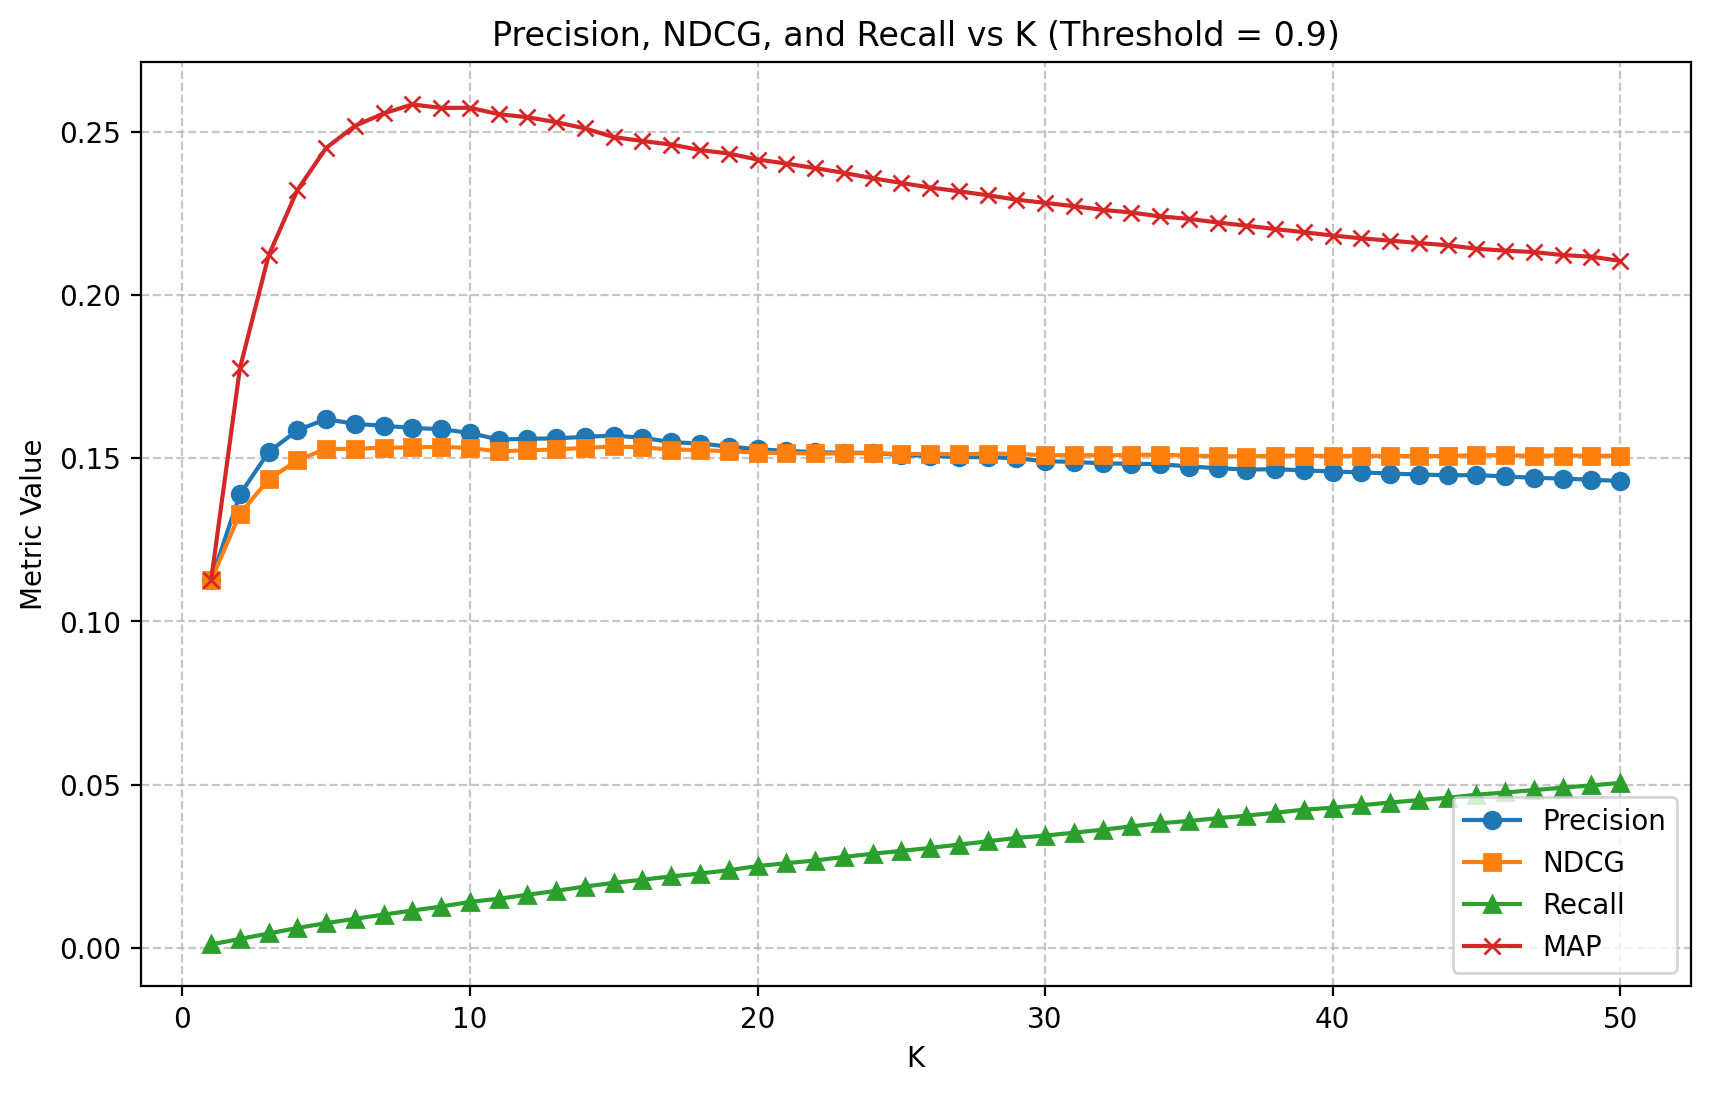

In [37]:
# Initialiser les listes pour stocker les résultats
ks = range(1, 51)
precisions = []
ndcgs = []
recalls = []
maps = []

# Calculer les métriques pour chaque valeur de k
for k in ks:
    if k % 10 == 0:
        print(f"Calculating metrics for k={k}...")
    evaluate = evaluate_implicit_at_k(predictions_pandas, k)   
    precisions.append(evaluate['precision'])
    ndcgs.append(evaluate['ndcg'])
    recalls.append(evaluate['recall'])
    maps.append(evaluate['map'])

# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.plot(ks, precisions, label="Precision", marker='o')
plt.plot(ks, ndcgs, label="NDCG", marker='s')
plt.plot(ks, recalls, label="Recall", marker='^')
plt.plot(ks, maps, label="MAP", marker='x')
plt.title("Precision, NDCG, and Recall vs K (Threshold = 0.9)")
plt.xlabel("K")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()